In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import tqdm
import gzip
from IPython.display import display
from PIL import Image
# from utils import extract_seq_from_fastq, get_umis
%matplotlib inline

# LVOT Pipeline
## 1. Preprocess fastq
## 2. Categorise UMI form the plasmid pool
## 3. UMI-base CRISPesso analysis
## 4. Statistiacl analysis on editing
## 5. Visualisation

# 1. preprocess fastq (extract UMI)

python move_umi_to_header_pool2.py (Archana and Linda)

# 2. categorise UMIs based on the target sequence from plasmid pool

In [195]:
maxi1_df = pd.read_csv('./UMI_extracted/trimmed_LV-Maxi-1_L001_R1_001.fastq.gz.extractedSeq.csv')
maxi2_df = pd.read_csv('./UMI_extracted/trimmed_LV-Maxi-2_L001_R1_001.fastq.gz.extractedSeq.csv')
maxi3_df = pd.read_csv('./UMI_extracted/trimmed_LV-Maxi-3_L001_R1_001.fastq.gz.extractedSeq.csv')
maxi1_df['Maxi_id'] = 'Maxi_1'
maxi2_df['Maxi_id'] = 'Maxi_2'
maxi3_df['Maxi_id'] = 'Maxi_3'
maxi_ds_all = pd.concat([maxi1_df, maxi2_df, maxi3_df])

In [198]:
def characterise_UMI_maxiPool(raw_reads_df):
    ot_info = pd.read_csv('../LVOT_Jiecong/OT_oligo_designs_ORIGINAL.csv')
    sel_columns = ['LVOTUMIv7 OT', 'Barcode (9 nt)', 'Protospacer + PAM (32 nt)', 'barcode+OT']
    df = raw_reads_df
    df['umi-Maxi'] = df['umi_r1'] + '-'+ df['Maxi_id']
    df['umi-maxi-barcode-ot'] =  df['umi_r1'] + '-'+ df['Maxi_id'] + '-' + df['barcode_r1'] + '-' + df['ot_r1']
    df['#Reads'] = df.groupby('umi-maxi-barcode-ot')['constant_r1'].transform('count')
    df['#Reads_UMI'] = df.groupby('umi-Maxi')['constant_r1'].transform('count')
    df['%Reads_UMI'] = (df['#Reads']/df['#Reads_UMI'])*100
    df_dedup = df.drop_duplicates(subset='umi-maxi-barcode-ot')
    df_dedup_otName = df_dedup.merge(ot_info[sel_columns], left_on='barcode_r1', right_on='Barcode (9 nt)', how='left')
    df_dedup_otName_sorted = df_dedup_otName.sort_values(by=['umi-Maxi','%Reads_UMI'])
    df_umiMaxiDedup_otName_sorted = df_dedup_otName_sorted.drop_duplicates(subset='umi-Maxi', keep='last').reset_index()
    df_umiMaxiDedup_otName_sorted['barcode+ot_r1'] = df_umiMaxiDedup_otName_sorted['barcode_r1'] + df_umiMaxiDedup_otName_sorted['ot_r1']
    df_umiMaxiDedup_otName_sorted['with_expectedOT'] = df_umiMaxiDedup_otName_sorted['barcode+OT'] == df_umiMaxiDedup_otName_sorted['barcode+ot_r1']
    print(len(df_umiMaxiDedup_otName_sorted[df_umiMaxiDedup_otName_sorted['with_expectedOT']])/len(df_umiMaxiDedup_otName_sorted))
    # df_umiMaxiDedup_otName_sorted.to_csv(sfn + '_MaxiUMI_dedup.csv', index=False)
    # with expected target sequence in all three maxi pool
    df_umiMaxiDedup_otName_sorted = df_umiMaxiDedup_otName_sorted.sort_values(by=['umi_r1', 'with_expectedOT'], ascending=False)
    df_umiDedup_otName_sorted = df_umiMaxiDedup_otName_sorted.drop_duplicates(subset='umi_r1', keep='first')
    print(len(df_umiDedup_otName_sorted[df_umiDedup_otName_sorted['with_expectedOT']])/len(df_umiDedup_otName_sorted))
    df_umiDedup_otName_sorted['UMI_type'] = 'dud'
    df_umiDedup_otName_sorted.loc[df_umiDedup_otName_sorted[(df_umiDedup_otName_sorted['with_expectedOT'])&(df_umiDedup_otName_sorted['%Reads_UMI']>90)].index, 'UMI_type'] = 'good'
    # df_umiDedup_otName_sorted.to_csv(sfn + '_UMI_dedup.csv', index=False)
    return df_umiDedup_otName_sorted

In [204]:
maxi_umi = characterise_UMI_maxiPool(maxi_ds_all)

0.849270113475236
0.838525967194408


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [81]:
maxi_umi.columns

Index(['Unnamed: 0', 'index', 'umi_r1', 'constant_r1', 'barcode_r1', 'ot_r1',
       'umi_r2', 'constant_r2', 'barcode_r2', 'ot_r2', 'Maxi_id', 'umi-Maxi',
       'umi-maxi-barcode-ot', '#Reads', '#Reads_UMI', '%Reads_UMI',
       'LVOTUMIv7 OT', 'Barcode (9 nt)', 'Protospacer + PAM (32 nt)',
       'barcode+OT', 'barcode+ot_r1', 'with_expectedOT', 'UMI_type'],
      dtype='object')

In [236]:
maxi_umi.groupby('Maxi_id')[['']]

,index,umi_r1,constant_r1,barcode_r1,ot_r1,umi_r2,constant_r2,barcode_r2,ot_r2,Maxi_id,...,#Reads,#Reads_UMI,%Reads_UMI,LVOTUMIv7 OT,Barcode (9 nt),Protospacer + PAM (32 nt),barcode+OT,barcode+ot_r1,with_expectedOT,UMI_type
13297613,5550125,TTTTTTTTTTTTTTTT,CACCAACCTCATAGAACACTCAT,CCTGACAGC,ATAGCAAAACAGGCAATTTTATCACTGGAACT,AAAAAAAAAAAAAAAA,ATGAGTGTTCTATGAGGTTGGTG,GCTGTCAGG,AGTTCCAGTGATAAAATTGCCTGTTTTGCTAT,Maxi_1,...,3.0,7,42.857143,NaN,NaN,NaN,NaN,CCTGACAGCATAGCAAAACAGGCAATTTTATCACTGGAACT,False,dud
13297611,10459418,TTTTTTTTTTTTTTTG,GGCCCAACCTCATAGAACACTCA,TCCTATACC,ACGGGGCTGTCCATCAGCACTAATAGTGGCAG,CAAAAAAAAAAAAAAA,TGAGTGTTCTATGAGGTTGGGCC,GGTATAGGA,CTGCCACTATTAGTGCTGATGGACAGCCCCGT,Maxi_1,...,1.0,8,12.500000,NaN,NaN,NaN,NaN,TCCTATACCACGGGGCTGTCCATCAGCACTAATAGTGGCAG,False,dud
13297608,4544171,TTTTTTTTTTTTTTTC,CCAACCTCATAGAACACTCATCC,AATCTCCAC,TATATGTTAGATGACATTGATAATGGGTTACA,GAAAAAAAAAAAAAAA,GGATGAGTGTTCTATGAGGTTGG,GTGGAGATT,TGTAACCCATTATCAATGTCATCTAACATATA,Maxi_1,...,7.0,19,36.842105,1450_OT_0243_ALT,AATCTCCAC,tataTGTTAGATGACATTGATAATGGgttaca,AATCTCCACTATATGTTAGATGACATTGATAATGGGTTACA,AATCTCCACTATATGTTAGATGACATTGATAATGGGTTACA,True,dud
13297606,16673654,TTTTTTTTTTTTTTTA,CCAACCTCATAGAACACTCATCA,TGTGAACTC,GTGCAGTCAGGAGGCATTGATAGTGGAGGCAG,TAAAAAAAAAAAAAAA,TGATGAGTGTTCTATGAGGTTGG,GAGTTCACA,CTGCCTCCACTATCAATGCCTCCTGACTGCAC,Maxi_2,...,1.0,1,100.000000,1450_OT_0264_ALT,TGTGAACTC,gtgcAGTCAGGAGGCATTGATAGTGGaggcag,TGTGAACTCGTGCAGTCAGGAGGCATTGATAGTGGAGGCAG,TGTGAACTCGTGCAGTCAGGAGGCATTGATAGTGGAGGCAG,True,good
13297602,3117579,TTTTTTTTTTTTTTGT,CCCAACCTCATAGAACACTCATC,CGGAGAAGA,AATGATGTTAGTTAGCACAGATAAGGGATGGG,ACAAAAAAAAAAAAAA,GATGAGTGTTCTATGAGGTTGGG,TCTTCTCCG,CCCATCCCTTATCTGTGCTAACTAACATCATT,Maxi_1,...,7.0,16,43.750000,NaN,NaN,NaN,NaN,CGGAGAAGAAATGATGTTAGTTAGCACAGATAAGGGATGGG,False,dud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,23536323,AAAAAAAAAAAAACAA,CCAACCACAAAGAACACTCATCC,CTCACCTTA,CGCGGCTTAATTGGCACTAATTGGGGTGGAGG,TAGAAAAAAAATTAAT,GGATGAGTGTTCTATGAGGTTGG,TAAGGTGAG,CCTCCACCCCAATTAGTGCCAATTAAGCCGCG,Maxi_3,...,1.0,1,100.000000,1450_OT_0206_ALT,CTCACCTTA,cgCGGCTTAATTGGCACTAATTGGGGtggagg,CTCACCTTACGCGGCTTAATTGGCACTAATTGGGGTGGAGG,CTCACCTTACGCGGCTTAATTGGCACTAATTGGGGTGGAGG,True,good
6,24061039,AAAAAAAAAAAAAATA,CCAACCTCATAGAACACTCATCC,TGATAAAAA,TAAAATAAAACAAAAATTATAACAGCAAAAAA,TAAGTTTGAAAATTAA,AATAAACAGGAATAATTTTAAAA,TGAATTAAA,AAATTGCCAATAAAAATATTGAC,Maxi_3,...,1.0,1,100.000000,NaN,NaN,NaN,NaN,TGATAAAAATAAAATAAAACAAAAATTATAACAGCAAAAAA,False,dud
5,18841122,AAAAAAAAAAAAAACA,CCAACCTCATAGAACACTCATCC,ATCGGCGAA,GCTACATTACCA,TGTATTATATTATAAT,GGATGAGTGTTCTATGAGGTTGG,TTCGCCGAT,AGTTAGCCCCTATCAGTGTCTGGTAAACTAGC,Maxi_2,...,1.0,2,50.000000,1450_OT_0179_ALT,ATCGGCGAA,gctagTTTACCAGACACTGATAGGGGctaact,ATCGGCGAAGCTAGTTTACCAGACACTGATAGGGGCTAACT,ATCGGCGAAGCTACATTACCA,False,dud
3,16535315,AAAAAAAAAAAAAAAT,AAAAAAAAAAAAAAAAAAAAAAA,AAAAAACAC,AAAAAATT,GAAATGCATAGTAATT,TGGATGAGTGTTCTATGAGGTTG,AGTGGAGAT,TGTAACCCATTATCAATGTCATCTAACATAT,Maxi_2,...,1.0,1,100.000000,NaN,NaN,NaN,NaN,AAAAAACACAAAAAATT,False,dud


In [80]:
# maxi_umi.to_csv('./umi_withLabel_fromThreeMaxiPools.csv')
maxi_umi = pd.read_csv('./umi_withLabel_fromThreeMaxiPools.csv')

In [134]:
good_maxi_umi = maxi_umi[maxi_umi['UMI_type'] == 'good']
dud_maxi_umi = maxi_umi[maxi_umi['UMI_type'] == 'dud']

In [348]:
good_maxi_umi_reads = good_maxi_umi.groupby('Maxi_id')[['#Reads']].count().reset_index()
good_maxi_umi_reads['umi'] = 'good'
good_maxi_umi_reads = good_maxi_umi_reads.rename(columns={'#Reads':'#Reads_good_umi'})

In [136]:
all_maxi_umi_reads = maxi_umi.groupby('Maxi_id')['#Reads'].count().reset_index()
all_maxi_umi_reads['umi'] = 'all'

In [349]:
dud_maxi_umi_reads = dud_maxi_umi.groupby('Maxi_id')['#Reads'].count().reset_index()
dud_maxi_umi_reads['umi'] = 'dud'
dud_maxi_umi_reads = dud_maxi_umi_reads.rename(columns={'#Reads':'#Reads_dud_umi'})

In [351]:
maxi_reads = pd.concat([good_maxi_umi_reads[['#Reads_good_umi']], dud_maxi_umi_reads], axis=1)

<IPython.core.display.Javascript object>


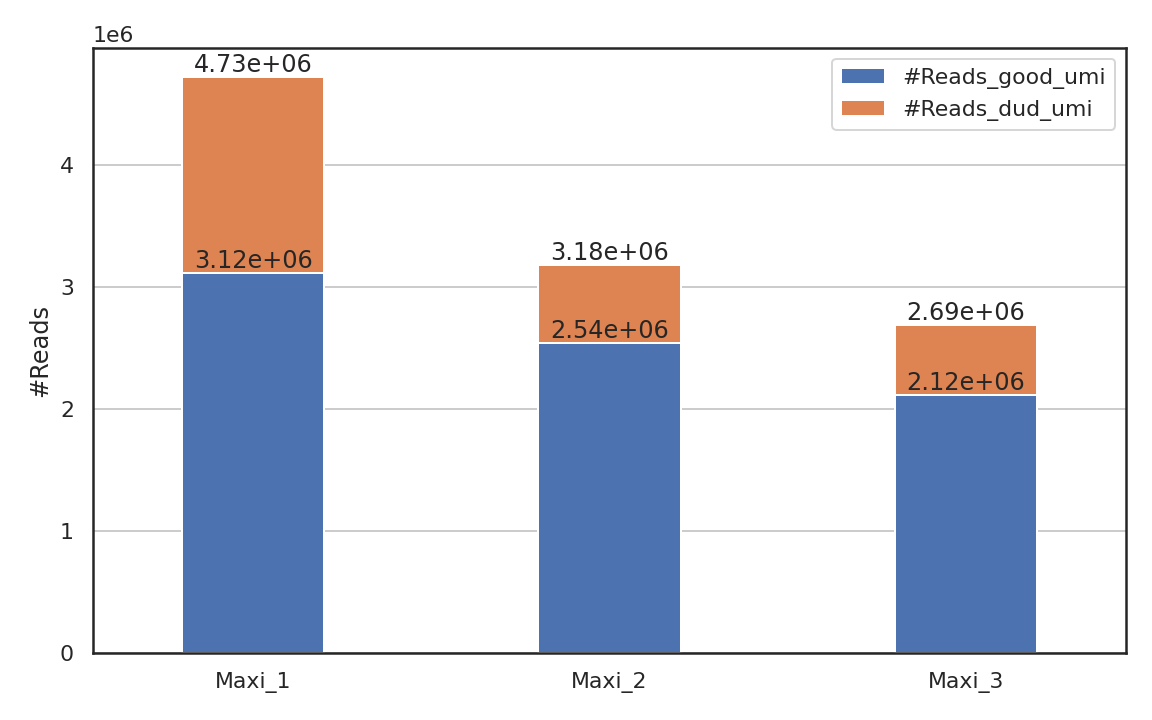

In [356]:
ax = maxi_reads.drop(columns=['umi']).set_index('Maxi_id').plot(kind='bar', stacked=True, figsize=(8, 5), width=0.4)
plt.xticks(rotation=0)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2e')
plt.xlabel('')
plt.ylabel('#Reads')
plt.grid(axis='y')
plt.tight_layout()

In [357]:
prompt_for_synthesis = 

NameError: name 'prompt_for' is not defined

Maxi_id
Maxi_1    4725615
Maxi_2    3184952
Maxi_3    2689577
Name: #Reads, dtype: int64

# 3. UMI-based CRISPResso editing analysis

In [83]:
r1_fn_list = glob.glob('./umi_in_header/LV-S*R1.fastq.gz')

In [446]:
amplicon_df = pd.read_csv('./OT_guide_amplicon_seq.csv', index_col='OT-Name')

In [115]:
# os.mkdir('./singleUMI_fastq')
# os.mkdir('./singleUMI_crispresso_input')
# os.mkdir('./singleUMI_crispresso')
def split_fastq_based_on_UMI(r1_fn, fa_out_folder='./singleUMI_fastq', crispress_input_folder = './singleUMI_crispresso_input', n_processes = 10):
    if not os.path.exists(fa_out_folder):
        os.mkdir(fa_out_folder)
    OT_name = r1_fn.split('/')[-1].split('_')[1]
    sample_name = r1_fn.split('/')[-1].replace('_R1.fastq.gz', '')
    fa_out_folder = fa_out_folder + '/' + sample_name
    if not os.path.exists(fa_out_folder):
        os.mkdir(fa_out_folder)
    all_umis = np.array(get_umis(r1_fn))[:-1]
    tdf = pd.DataFrame(index=all_umis)
    tdf['line_0'] = np.arange(len(all_umis))*4
    tdf = tdf.reset_index()
    input_df = pd.DataFrame()
    # print(OT_name)
    amplicon_seq = amplicon_df.loc[OT_name, 'amplicon_seq']
    guide_seq = amplicon_df.loc[OT_name, 'guide_seq']
    for umi in tqdm.tqdm(set(all_umis)):
        select_line = list(tdf[tdf['index'] == umi]['line_0'])
        umi_r1_fn = out_folder + '/' + umi + '_R1.fastq.gz'
        ot_r1 = gzip.open(umi_r1_fn, 'wt')
        ot_r2 = gzip.open(umi_r1_fn.replace('R1', 'R2'), 'wt')
        with gzip.open(r1_fn, 'rt') as r1_fastq,\
                gzip.open(r1_fn.replace("R1","R2"), 'rt') as r2_fastq:
            r1_lines = r1_fastq.readlines()
            r2_lines = r2_fastq.readlines()
            for li in select_line:
                for i in range(4):
                    ot_r1.write(r1_lines[li+i])
                    ot_r2.write(r2_lines[li+i])
        ot_r1.close()
        ot_r2.close()
        # build input file for CRISPResso
        input_df = input_df.append({'name':umi, 'fastq_r1':umi_r1_fn, 'fastq_r2':umi_r1_fn.replace('R1', 'R2'), 'amplicon_seq':amplicon_seq, 'guide_seq':guide_seq}, ignore_index=True)
        input_df = input_df[['name', 'fastq_r1', 'fastq_r2', 'amplicon_seq', 'guide_seq']]
        if not os.path.exists(crispress_input_folder):
            os.mkdir(crispress_input_folder)
        input_fn = crispress_input_folder + '/' + sample_name + '_input.tsv'
        input_df.to_csv(input_fn,  index=False, sep='\t')
        # make crispressoBatch cmd
        cmd = "CRISPRessoBatch --batch_settings " + input_fn + " --batch_output_folder ./singleUMI_crispresso/CRISPResso_on_" + sample_name + \
                " --n_processes " +str(n_processes)+ " --ignore_substitutions --min_frequency_alleles_around_cut_to_plot 0 --skip_failed --write_detailed_allele_table --plot_window_size 10"
    return cmd

In [116]:
crispresso_cmd = split_fastq_based_on_UMI('./umi_in_header/LV-S1_1450-OT-0000-REF_R1.fastq.gz')

100%|██████████| 1296/1296 [02:33<00:00,  8.43it/s]


In [123]:
crispresso_cmd

'CRISPRessoBatch --batch_settings ./singleUMI_crispresso_input/LV-S1_1450-OT-0000-REF_input.tsv --batch_output_folder ./singleUMI_crispresso/CRISPResso_on_LV-S1_1450-OT-0000-REF --n_processes 10 --ignore_substitutions --min_frequency_alleles_around_cut_to_plot 0 --skip_failed --write_detailed_allele_table --plot_window_size 10'

In [144]:
LV_group = pd.read_csv('./NovaSeq3_sample_info.csv')
LV_group = LV_group[LV_group['Cas_type']!='WT']
lv_ids = list(LV_group['short_name'])
key_ot_list = ['1450_OT_0203_ALT', '1450_OT_0206_ALT', '1450_OT_0264_ALT', '1617_OT_0398_ALT', '1450_OT_0329_ALT', '1450_OT_0274_ALT', '1617_OT_0000_REF', '1450_OT_0000_REF']
LV_group = LV_group.set_index('short-name')

## obtain umi-allele table from raw reads

In [221]:
def combine_allele_table(sample_name, out_folder = './singleUMI_allele_table/raw/'):
    lvid = sample_name.split('_')[0].replace('-', '_')
    ot = sample_name.split('_')[1]
    LV_cvt = pd.read_csv('./LV_id_name_converted.csv', index_col=0)
    Rep_i =  LV_cvt.loc[lvid, 'Rep']
    group_i = LV_cvt.loc[lvid, 'Cas_type']
    donor_i = LV_cvt.loc[lvid, 'donor_id']
    out_name = ot + '_' + donor_i + '_' + group_i + '_' + Rep_i + '_' + lvid
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    # CRISPResso_on_LV-S1_1450-OT-0000-REF/CRISPRessoBatch_on_LV-S1_1450-OT-0000-REF_input
    alleles_fns = glob.glob('./singleUMI_crispresso/CRISPResso_on_'+sample_name+'/CRISPRessoBatch_on_'+sample_name+'_input/CRISPResso_on_*/Alleles_frequency_table_around_sgRNA*')
    umi_allele_list = []
    for fn in alleles_fns:
        umi_seq = fn.split('/')[-2].split('_')[-1]
        df = pd.read_csv(fn, sep='\t')
        df['UMI'] = umi_seq
        umi_allele_list.append(df)
    umi_allele_df = pd.concat(umi_allele_list).reset_index()
    umi_allele_df = umi_allele_df.rename(columns={'%Reads':'%Reads_UMI'})
    umi_allele_df['%Reads'] = umi_allele_df['#Reads']/umi_allele_df['#Reads'].sum() * 100
    umi_allele_df['UMI|Alelle'] = umi_allele_df['UMI'] + '|' + umi_allele_df['Aligned_Sequence']
    umi_allele_df['sample_id'] = sample_name
    umi_allele_df['donor'] = donor_i
    umi_allele_df['replicate'] = Rep_i
    umi_allele_df['group'] = group_i
    umi_allele_df['OT_name'] = ot
    print(out_name)
    umi_allele_df.to_csv(out_folder + '/' + out_name + '_Allele_frequency_table_withUMI.txt', sep='\t')
    return umi_allele_df

In [222]:
!ls './singleUMI_allele_table/raw/'

1450-OT-0000-REF_D3734_HiFi_T1_LV_S1_Allele_frequency_table_withUMI.txt


In [429]:
pd.read_csv('./LV_id_name_converted.csv')

,short_name,full_name,donor,donor_id,Cas_type,name,Rep
0,LV_S1,LV_LVOT_030922_D3734_vPool_10uL_HiFi_T1,D3734_HiFi,D3734,HiFi,D3734_HiFi_T1,T1
1,LV_S2,LV_LVOT_030922_D3734_vPool_10uL_HiFi_T2,D3734_HiFi,D3734,HiFi,D3734_HiFi_T2,T2
2,LV_S3,LV_LVOT_030922_D3734_vPool_10uL_No_EP_T1,D3734_NoEP,D3734,NoEP,D3734_NoEP_T1,T1
3,LV_S4,LV_LVOT_030922_D3734_vPool_10uL_No_EP_T2,D3734_NoEP,D3734,NoEP,D3734_NoEP_T2,T2
4,LV_S5,LV_LVOT_030922_D3734_vPool_10uL_No_EP_T3,D3734_NoEP,D3734,NoEP,D3734_NoEP_T3,T3
5,LV_S9,LV_LVOT_030922_D3742_vPool_10uL_HiFi_T1,D3742_HiFi,D3742,HiFi,D3742_HiFi_T1,T1
6,LV_S10,LV_LVOT_030922_D3742_vPool_10uL_HiFi_T2,D3742_HiFi,D3742,HiFi,D3742_HiFi_T2,T2
7,LV_S11,LV_LVOT_030922_D3742_vPool_10uL_HiFi_T3,D3742_HiFi,D3742,HiFi,D3742_HiFi_T3,T3
8,LV_S12,LV_LVOT_030922_D3742_vPool_10uL_No_EP_T1,D3742_NoEP,D3742,NoEP,D3742_NoEP_T1,T1
9,LV_S13,LV_LVOT_030922_D3742_vPool_10uL_No_EP_T2,D3742_NoEP,D3742,NoEP,D3742_NoEP_T2,T2


In [263]:
allele_table = combine_allele_table('LV-S1_1450-OT-0000-REF')

1450-OT-0000-REF_D3734_HiFi_T1_LV_S1


In [358]:
# allele_table

# 4. UMI-based statistical analysis

In [194]:
# remove umi/read <= 1
def filter_low_reads_umiallele(df):
    filtered_df = df[df['#Reads'] > 1].reset_index()
    filtered_df['%Reads'] = filtered_df['#Reads']/filtered_df['#Reads'].sum() * 100
    return filtered_df

def deduplicate_umiallele(df):
    tdf = df.sort_values(by=['UMI', '%Reads_UMI'], ascending=False)
    tdf_dedup = tdf.drop_duplicates(subset='UMI', keep='first')
    filtered_df = tdf_dedup[tdf_dedup['%Reads_UMI'] > 65].reset_index()
    filtered_df['#Reads'] = 1
    filtered_df['%Reads'] = filtered_df['#Reads']/filtered_df['#Reads'].sum() * 100
    return filtered_df

In [268]:
# label the UMI for each sample
maxi_ds_df = maxi_umi # pd.read_csv('./')
for fn in tqdm.tqdm(glob.glob('./singleUMI_allele_table/raw/*txt')):
    out_name = fn.split('/')[-1]
    allele_df = pd.read_csv(fn, sep='\t')
    ot_name = allele_df.iloc[0]['OT_name'].replace('-', '_')
    OT_maxi_df = maxi_ds_df[maxi_ds_df['LVOTUMIv7 OT'] == ot_name].reset_index()[['umi_r1', 'UMI_type']]
    allele_maxi_df = allele_df.merge(OT_maxi_df, how='left', left_on='UMI', right_on='umi_r1')
    allele_maxi_df.loc[allele_maxi_df[allele_maxi_df['UMI_type'].isna()].index, 'UMI_type'] = 'unseen'
    allele_maxi_df.to_csv(fn, index=False, sep='\t')

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


## UMI-based filtering

In [271]:
for fn in tqdm.tqdm(glob.glob('./singleUMI_allele_table/raw/*txt')):
    out_name = fn.split('/')[-1]
    allele_df = pd.read_csv(fn, sep='\t')
    allele_df['UMI-Aligned_Sequence'] = allele_df['UMI'] + '-' + allele_df['Aligned_Sequence']
    donor = allele_df.iloc[0]['donor']
    edit = allele_df.iloc[0]['group']
    allele_deduplicate_df = deduplicate_umiallele(allele_df).drop(columns='level_0')
    
    # 1. Raw + deduplicate
    out_folder = './singleUMI_allele_table/raw_deduplicate/'
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    out_fn = out_folder + out_name
    allele_deduplicate_df.to_csv(out_fn, sep='\t')
    # ot_name = allele_df.iloc[0]['OT_name'].replace('-', '_')
    
    # 2 .dedudStringent
    umi_type_name = 'UMI_type'
    dedud_df = allele_df[allele_df[umi_type_name] == 'good'].reset_index()
    dedud_df['%Reads'] = dedud_df['#Reads']/dedud_df['#Reads'].sum() * 100
    dedud_df = dedud_df.drop(columns='level_0')
    out_folder = './singleUMI_allele_table/dedudStringent/'
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    dedud_df.to_csv(out_folder + out_name, sep='\t', index=False)
    
    # 3. dedudStringent + deduplicate
    out_folder = './singleUMI_allele_table/dedudStringent_deduplicate/'
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    out_fn = out_folder + out_name
    allele_deduplicate_df = deduplicate_umiallele(dedud_df).drop(columns='level_0')
    allele_deduplicate_df.to_csv(out_fn, sep='\t')

100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


## Statistical analysis
###  1. Indel estimation : on_offTargetModelling.R
###  2. Power analysis: on_offTargetPowerAnalysis.R

# 5. Visualisation

## Marginal indel estimation

In [1080]:
margin_res = pd.read_csv('./CRISPRessoBatch_alleles_umi/globalResults_raw_dedudStringentV3_effects_compare/summaryResultsAllSettingsPowerMarginal', sep='\t')
margin_res['marginalPredDelta'] = margin_res['marginalPredTrear'] - margin_res['marginalPredCrtl'] 
margin_res['significant'] = (margin_res['adjpvalue'] < 0.05)&(margin_res['marginalPredDelta']>0.1/100)
margin_res_pivot = margin_res.pivot("offtarget", "folder", "significant")

In [1081]:
# pd.read_csv('./CRISPRessoBatch_alleles_umi/globalResults_raw_dedudStringentV3_effects_compare/summaryResultsAllSettingsPowerMarginal', sep='\t')

In [1099]:
sns.set_theme('paper')
%matplotlib notebook

<IPython.core.display.Javascript object>


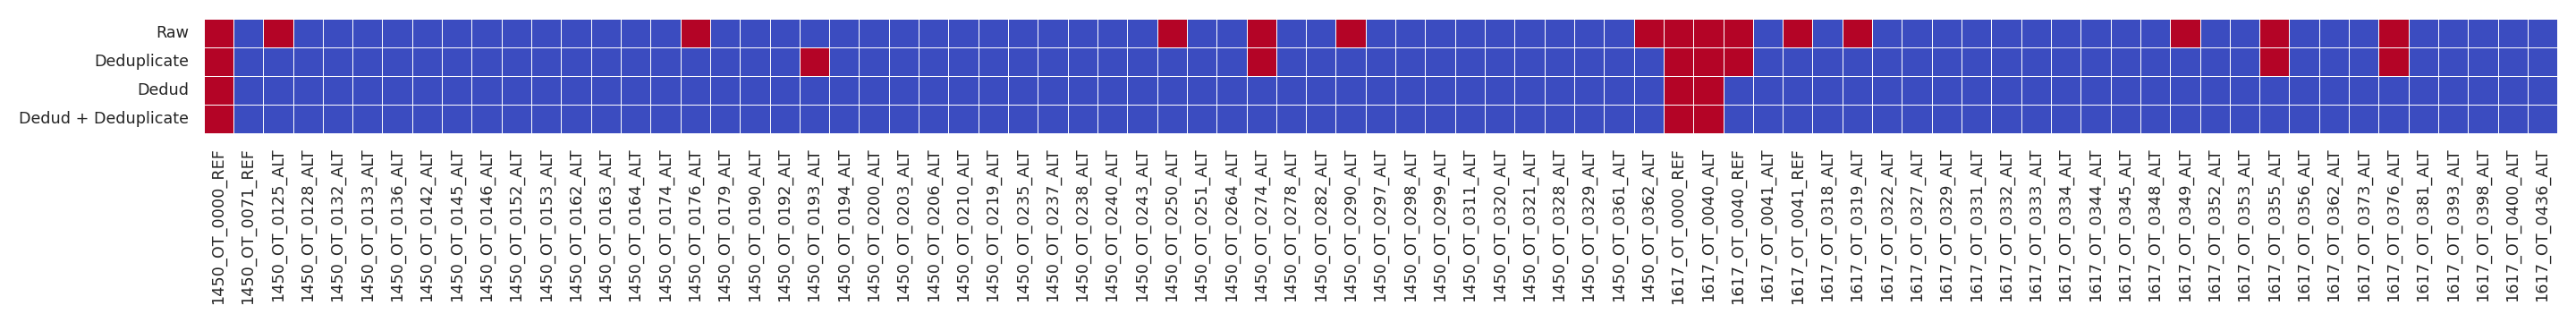

In [1107]:
fig, ax = plt.subplots(figsize=(20, 2.5))
ax = sns.heatmap(margin_res_pivot[['raw', 'raw_deduplicateS', 'dedudStringentV3','dedudStringentV3_deduplicateS']].T,  cmap='coolwarm', linewidth=.5, cbar_kws={'shrink': 0.5}, cbar=False, ax=ax)
ax.set(xlabel="", ylabel="",) # B>0, alpha=0.05, HiFi-NoEP > 0.1%
ax.set_yticklabels(['Raw', 'Deduplicate', 'Dedud', 'Dedud + Deduplicate'])
# sns.set(font_scale=1.4)
plt.title('')
plt.tight_layout()
# plt.savefig('./figure_forManuscript/heatmap_sigLocus.pdf', bbox_inches = 'tight')

## Donor-specfic indel estimation 

In [414]:
heatmap_EST_noEP_list = []
heatmap_EST_HiFi_list = []
heatmap_SIG_HiFi_list = []
heatmap_CI_NoEP_list = []
heatmap_CI_HiFi_list = []
all_df_list = []
ds_size = ''
for n in ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS']:
    print(n)
    target_res_list = []
    for fn in glob.glob('././CRISPRessoBatch_alleles_umi/' + n + '/results/*'):
        if not fn.endswith('.png'):
            df = pd.read_csv(fn, sep='\t')
            df['Target'] = fn.split('/')[-1]
            target_res_list.append(df)
    danlio_res_df = pd.concat(target_res_list)
    danlio_res_df['conf.interval'] = danlio_res_df['conf.high'] - danlio_res_df['conf.low']
    danlio_res_df['name'] = danlio_res_df['Target'] + '-' + danlio_res_df['Donor'] + '-' + danlio_res_df['Treat']
    danlio_res_df['filtering_strategy'] = n
    all_df_list.append(danlio_res_df)
    noEP_res_df = danlio_res_df[danlio_res_df['Treat'] == 'NoEP']
    hifi_res_df = danlio_res_df[danlio_res_df['Treat'] == 'HiFi']
    noEP_res_dedup_df = noEP_res_df.drop_duplicates(subset='name')
    hifi_res_dedup_df = hifi_res_df.drop_duplicates(subset='name')
    
    heatmap_hifi_df = hifi_res_dedup_df.pivot("Target", "Donor", "predicted")
    hifi_res_dedup_df['Significant'] = (hifi_res_dedup_df['pvalueTreatPval'] < 0.05)&(hifi_res_dedup_df['pvalueTreatEst']>0)
    heatmap_hifi_sig_df = hifi_res_dedup_df.pivot("Target", "Donor", "Significant")
    heatmap_noEP_df = noEP_res_dedup_df.pivot("Target", "Donor", "predicted")
    for di in ['D3734', 'D3742', 'D3908']:
        heatmap_noEP_df = heatmap_noEP_df.rename(columns={di:di+'_'+n})
        heatmap_hifi_df = heatmap_hifi_df.rename(columns={di:di+'_'+n})
        heatmap_hifi_sig_df = heatmap_hifi_sig_df.rename(columns={di:di+'_'+n})
    heatmap_SIG_HiFi_list.append(heatmap_hifi_sig_df)
    heatmap_EST_HiFi_list.append(heatmap_hifi_df)
    heatmap_EST_noEP_list.append(heatmap_noEP_df)
    
    heatmap_hifi_df = hifi_res_dedup_df.pivot("Target", "Donor", "conf.interval")
    heatmap_noEP_df = noEP_res_dedup_df.pivot("Target", "Donor", "conf.interval")
    for di in ['D3734', 'D3742', 'D3908']:
        heatmap_noEP_df = heatmap_noEP_df.rename(columns={di:di+'_'+n})
        heatmap_hifi_df = heatmap_hifi_df.rename(columns={di:di+'_'+n})
    heatmap_CI_NoEP_list.append(heatmap_noEP_df)
    heatmap_CI_HiFi_list.append(heatmap_hifi_df)
    
all_df = pd.concat(all_df_list)
heatmap_EST_merged_noEP_df = pd.concat(heatmap_EST_noEP_list, axis=1)
heatmap_SIG_merged_HiFi_df = pd.concat(heatmap_SIG_HiFi_list, axis=1)
heatmap_EST_merged_HiFi_df = pd.concat(heatmap_EST_HiFi_list, axis=1)
heatmap_CI_merged_NoEP_df = pd.concat(heatmap_CI_NoEP_list, axis=1)
heatmap_CI_merged_HiFi_df = pd.concat(heatmap_CI_HiFi_list, axis=1)
heatmap_EST_delta_df = heatmap_EST_merged_HiFi_df - heatmap_EST_merged_noEP_df
heatmap_EST_merged_sig_df = heatmap_EST_delta_df> 0.1/100
all_df = pd.concat(all_df_list)

raw


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


raw_deduplicateS


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dedudStringentV3


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dedudStringentV3_deduplicateS


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [415]:
all_df

,Donor,Treat,cInd,cTot,S,xs,col,cNet,predicted,std.error,conf.high,conf.low,ys,pvalueTreatPval,pvalueTreatEst,pvalueSigEffectPos,Target,conf.interval,name,filtering_strategy
0,D3734,HiFi,15615,19357,S1,1.1,cornflowerblue,3742,0.796466,0.012219,0.800321,0.792556,0.806685,0.000000,8.271623,0,1450_OT_0000_REF,0.007765,1450_OT_0000_REF-D3734-HiFi,raw
1,D3742,HiFi,17954,22903,S2,2.1,cornflowerblue,4949,0.781375,0.010542,0.784884,0.777825,0.783915,0.000000,8.271623,0,1450_OT_0000_REF,0.007059,1450_OT_0000_REF-D3742-HiFi,raw
2,D3742,HiFi,5816,7524,S3,2.1,cornflowerblue,1708,0.781375,0.010542,0.784884,0.777825,0.772993,0.000000,8.271623,0,1450_OT_0000_REF,0.007059,1450_OT_0000_REF-D3742-HiFi,raw
3,D3742,NoEP,111,84031,S4,1.9,grey40,83920,0.000913,0.042280,0.000992,0.000840,0.001321,0.000000,8.271623,0,1450_OT_0000_REF,0.000151,1450_OT_0000_REF-D3742-NoEP,raw
4,D3742,NoEP,85,91223,S5,1.9,grey40,91138,0.000913,0.042280,0.000992,0.000840,0.000932,0.000000,8.271623,0,1450_OT_0000_REF,0.000151,1450_OT_0000_REF-D3742-NoEP,raw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,D3908,NoEP,0,1617,S19,2.9,grey40,1617,0.000084,1.334285,0.001145,0.000006,0.000000,0.515998,-0.053403,0,1617_OT_0436_ALT,0.001139,1617_OT_0436_ALT-D3908-NoEP,dedudStringentV3_deduplicateS
13,D3734,NoEP,1,2464,S20,0.9,grey40,2463,0.000211,0.815583,0.001041,0.000043,0.000406,0.515998,-0.053403,0,1617_OT_0436_ALT,0.000998,1617_OT_0436_ALT-D3734-NoEP,dedudStringentV3_deduplicateS
14,D3734,NoEP,0,2140,S21,0.9,grey40,2140,0.000211,0.815583,0.001041,0.000043,0.000000,0.515998,-0.053403,0,1617_OT_0436_ALT,0.000998,1617_OT_0436_ALT-D3734-NoEP,dedudStringentV3_deduplicateS
15,D3734,NoEP,0,1815,S22,0.9,grey40,1815,0.000211,0.815583,0.001041,0.000043,0.000000,0.515998,-0.053403,0,1617_OT_0436_ALT,0.000998,1617_OT_0436_ALT-D3734-NoEP,dedudStringentV3_deduplicateS


<IPython.core.display.Javascript object>


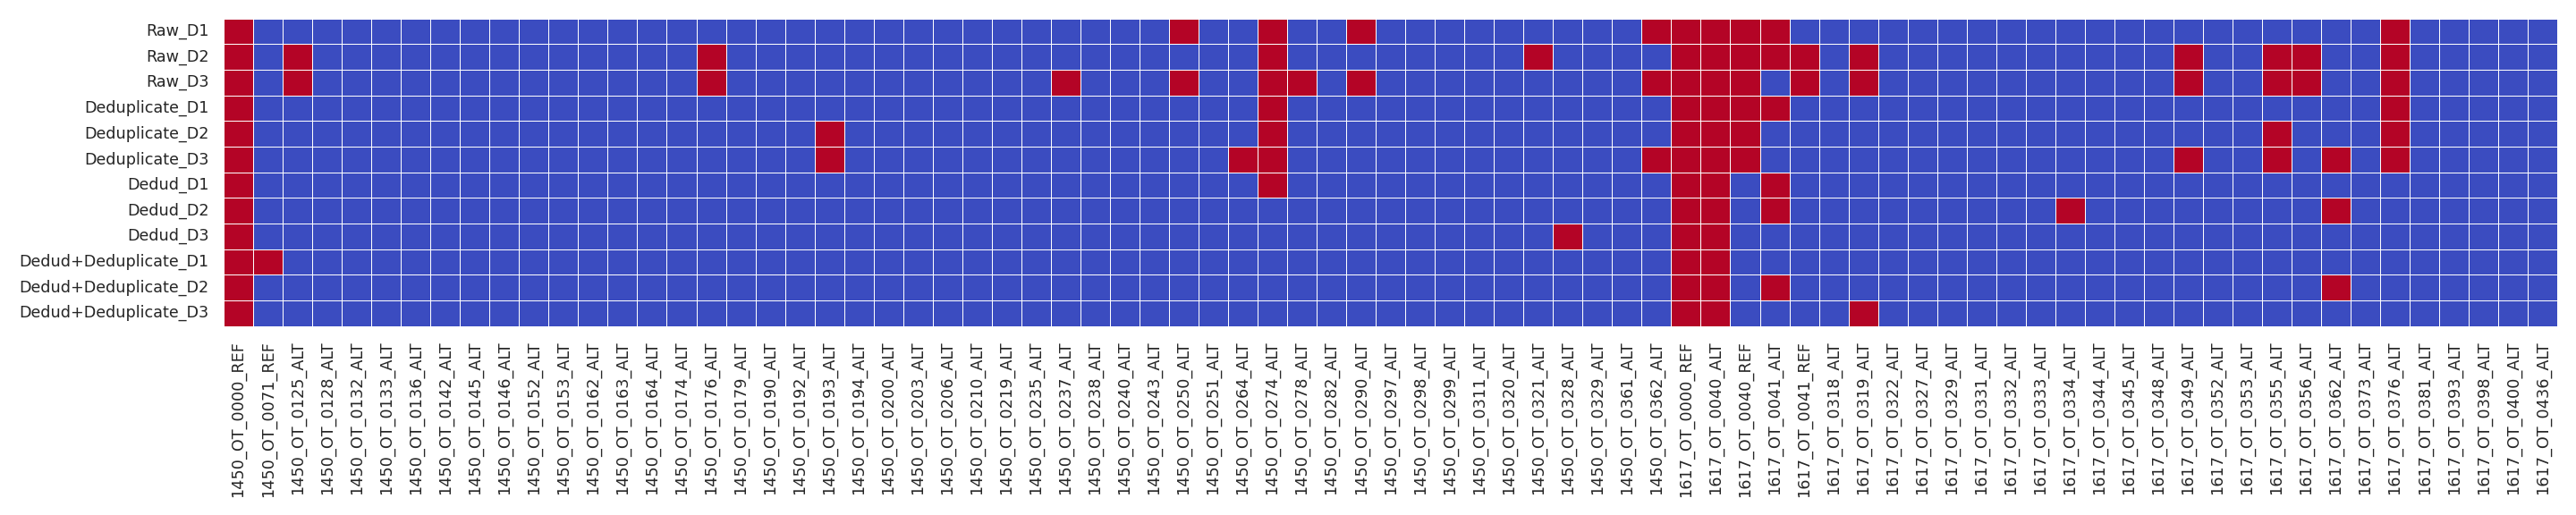

In [1104]:
fig, ax = plt.subplots(figsize=(20, 4))
ax = sns.heatmap(heatmap_EST_merged_sig_df.T*heatmap_SIG_merged_HiFi_df.T.astype(int), cmap='coolwarm', linewidth=.5, cbar_kws={'shrink': 0.5},  cbar=False, ax =ax)
ax.set(xlabel="", ylabel="")
ax.set_yticklabels(['Raw_D1', 'Raw_D2','Raw_D3', 'Deduplicate_D1','Deduplicate_D2','Deduplicate_D3', 'Dedud_D1','Dedud_D2','Dedud_D3', 
                     'Dedud+Deduplicate_D1', 'Dedud+Deduplicate_D2', 'Dedud+Deduplicate_D3'])
# plt.savefig('./figure_forManuscript/heatmap_sigLocus_donor.pdf', bbox_inches = 'tight')

# plt.title('Significant Locus (HiFi-NoEP > 0.1% and pvalueTreatPval<0.05)')
plt.tight_layout()

# Donor-specfic indel estimation on NoEP

In [346]:
heatmap_EST_merged_noEP_df.describe()

Donor,D3734_raw,D3742_raw,D3908_raw,D3734_raw_deduplicateS,D3742_raw_deduplicateS,D3908_raw_deduplicateS,D3734_dedudStringentV3,D3742_dedudStringentV3,D3908_dedudStringentV3,D3734_dedudStringentV3_deduplicateS,D3742_dedudStringentV3_deduplicateS,D3908_dedudStringentV3_deduplicateS
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,7.900000e+01,7.900000e+01,7.900000e+01,79.000000,79.000000,79.000000
mean,0.001700,0.001815,0.002102,0.002050,0.002056,0.002288,1.134527e-04,1.190201e-04,1.136436e-04,0.000295,0.000321,0.000260
std,0.001193,0.001303,0.001823,0.001550,0.001545,0.001883,2.299664e-04,3.040807e-04,2.830895e-04,0.001157,0.001187,0.000789
min,0.000383,0.000306,0.000315,0.000775,0.000543,0.000597,1.428607e-07,3.561874e-07,2.023979e-07,0.000007,0.000006,0.000009
25%,0.000950,0.000920,0.001147,0.001225,0.001292,0.001296,5.155023e-06,8.219341e-06,4.883658e-06,0.000032,0.000035,0.000044
50%,0.001366,0.001474,0.001557,0.001583,0.001637,0.001759,1.846622e-05,2.114301e-05,2.092026e-05,0.000048,0.000049,0.000060
75%,0.001992,0.002323,0.002505,0.002055,0.002129,0.002377,6.876077e-05,6.607720e-05,5.255826e-05,0.000135,0.000129,0.000192
max,0.007473,0.007408,0.010248,0.009987,0.010339,0.011488,1.199047e-03,1.807254e-03,1.816780e-03,0.008711,0.009330,0.006121


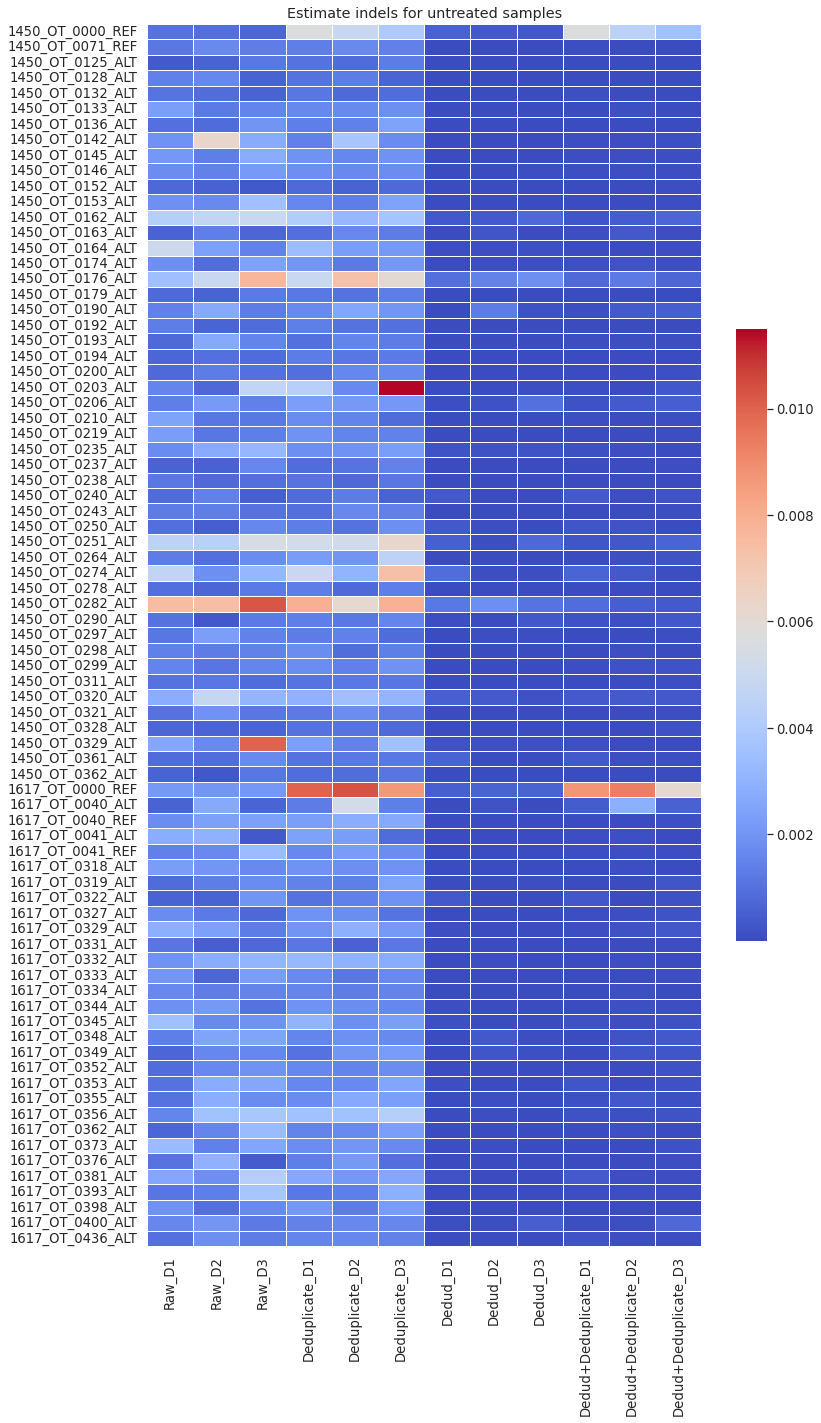

In [391]:
fig, ax = plt.subplots(figsize=(12, 20))
ax = sns.heatmap(heatmap_EST_merged_noEP_df, cmap='coolwarm', linewidth=.5, cbar_kws={'shrink': 0.5}, ax =ax)
ax.set(xlabel="", ylabel="", title='Estimate indels for untreated samples')
ax.set_xticklabels(['Raw_D1', 'Raw_D2','Raw_D3', 'Deduplicate_D1','Deduplicate_D2','Deduplicate_D3', 'Dedud_D1','Dedud_D2','Dedud_D3', 
                     'Dedud+Deduplicate_D1', 'Dedud+Deduplicate_D2', 'Dedud+Deduplicate_D3'])
plt.savefig('./figure_forManuscript/heatmap_indelEst_untreated_donor.pdf', bbox_inches = 'tight')
sns.set(font_scale=1.2)
# plt.title('Significant Locus (HiFi-NoEP > 0.1% and pvalueTreatPval<0.05)')
plt.tight_layout()

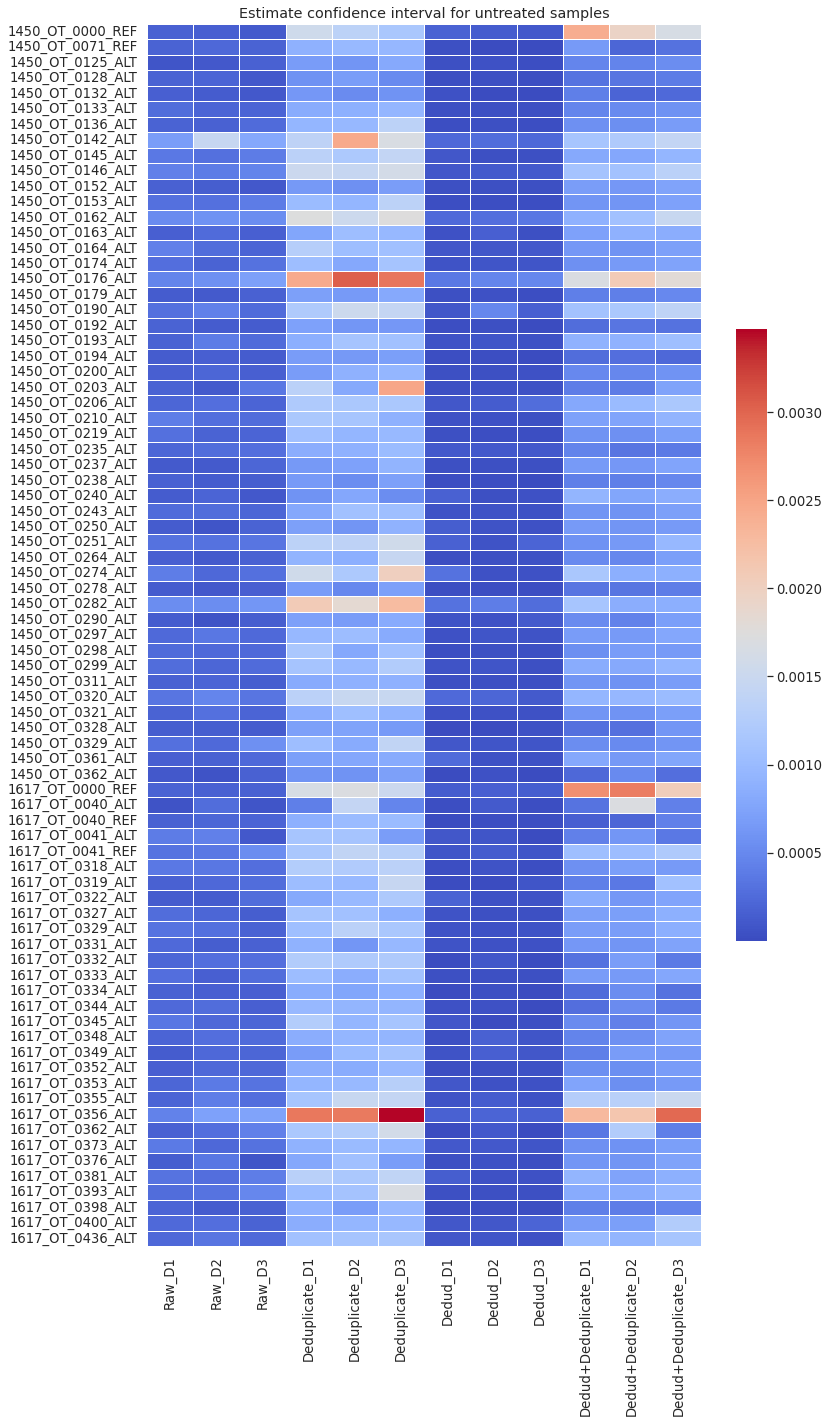

In [392]:
fig, ax = plt.subplots(figsize=(12, 20))
ax = sns.heatmap(heatmap_CI_merged_NoEP_df, cmap='coolwarm', linewidth=.5, cbar_kws={'shrink': 0.5}, ax=ax)
ax.set(xlabel="", ylabel="", title='Estimate confidence interval for untreated samples')
ax.set_xticklabels(['Raw_D1', 'Raw_D2','Raw_D3', 'Deduplicate_D1','Deduplicate_D2','Deduplicate_D3', 'Dedud_D1','Dedud_D2','Dedud_D3', 
                     'Dedud+Deduplicate_D1', 'Dedud+Deduplicate_D2', 'Dedud+Deduplicate_D3'])
plt.savefig('./figure_forManuscript/heatmap_confInt_untreated_donor.pdf', bbox_inches = 'tight')
sns.set(font_scale=1.2)
# plt.title('Significant Locus (HiFi-NoEP > 0.1% and pvalueTreatPval<0.05)')
plt.tight_layout()

# Power Analysis

In [343]:
raw = pd.read_csv('/data/pinello/PROJECTS/2022_04_LVOT/trimmed_fastq_vpooled_all/CRISPRessoBatch_alleles_umi/power_analysis/raw_effectSize0.001.tsv', sep='\t')
raw_dup = pd.read_csv('/data/pinello/PROJECTS/2022_04_LVOT/trimmed_fastq_vpooled_all/CRISPRessoBatch_alleles_umi/power_analysis/raw_deduplicateS_effectSize0.001.tsv', sep='\t')
dedudv3 = pd.read_csv('/data/pinello/PROJECTS/2022_04_LVOT/trimmed_fastq_vpooled_all/CRISPRessoBatch_alleles_umi/power_analysis/dedudStringentV3_effectSize0.001.tsv', sep='\t')
dedudv3_dup = pd.read_csv('/data/pinello/PROJECTS/2022_04_LVOT/trimmed_fastq_vpooled_all/CRISPRessoBatch_alleles_umi/power_analysis/dedudStringentV3_deduplicateS_effectSize0.001.tsv', sep='\t')
raw_merge = raw.merge(raw_dup, on='target', suffixes=['_raw', '_raw_duplicate'])
dedudv3_merge = dedudv3.merge(dedudv3_dup, on='target', suffixes=['_dedud', '_dedud_deplicate'])
all_merge = raw_merge.merge(dedudv3_merge, on='target')

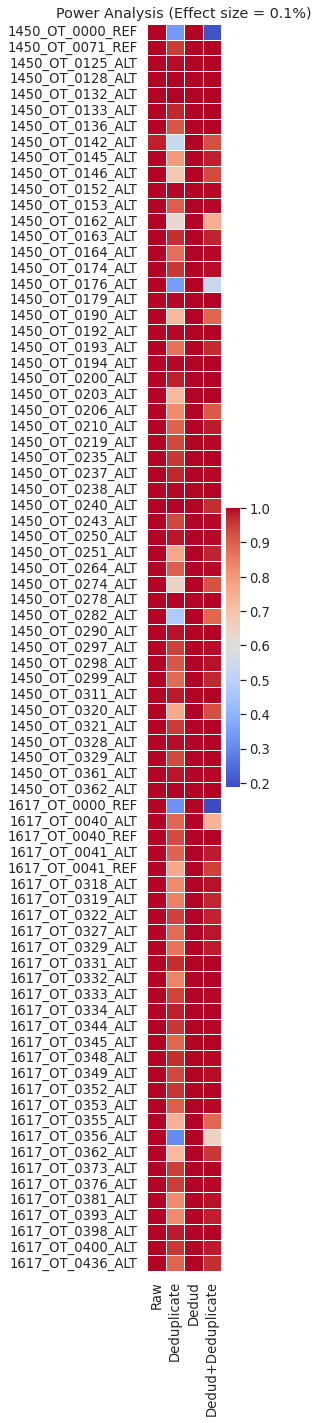

In [395]:
fig, ax = plt.subplots(figsize=(4, 20))
ax = sns.heatmap(all_merge.set_index('target')[['power_raw', 'power_raw_duplicate', 'power_dedud', 'power_dedud_deplicate']], cmap='coolwarm',cbar_kws={'shrink': 0.5}, linewidth=.5, ax = ax)
ax.set(xlabel="", ylabel="", title='Power Analysis (Effect size = 0.1%)')
ax.set_xticklabels(['Raw', 'Deduplicate', 'Dedud', 'Dedud+Deduplicate'])
plt.savefig('./figure_forManuscript/heatmap_powerAnlysis_01es.pdf', bbox_inches = 'tight')
sns.set(font_scale=1.2)
# plt.title('Significant Locus (HiFi-NoEP > 0.1% and pvalueTreatPval<0.05)')
plt.tight_layout()
# plt.xticks([0.5, 1.5, 2.5, 3.5], ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS'], rotation=90)
# plt.title('Power Analysis\n(Effect size = 0.1%)', fontsize=12)

In [396]:
raw = pd.read_csv('/data/pinello/PROJECTS/2022_04_LVOT/trimmed_fastq_vpooled_all/CRISPRessoBatch_alleles_umi/power_analysis/raw.tsv', sep='\t')
raw_dup = pd.read_csv('/data/pinello/PROJECTS/2022_04_LVOT/trimmed_fastq_vpooled_all/CRISPRessoBatch_alleles_umi/power_analysis/raw_deduplicateS_effectSize0.0001.tsv', sep='\t')
dedudv3 = pd.read_csv('/data/pinello/PROJECTS/2022_04_LVOT/trimmed_fastq_vpooled_all/CRISPRessoBatch_alleles_umi/power_analysis/dedudStringentV3.tsv', sep='\t')
dedudv3_dup = pd.read_csv('/data/pinello/PROJECTS/2022_04_LVOT/trimmed_fastq_vpooled_all/CRISPRessoBatch_alleles_umi/power_analysis/dedudStringentV3_deduplicateS.tsv', sep='\t')
raw_merge = raw.merge(raw_dup, on='target', suffixes=['_raw', '_raw_duplicate'])
dedudv3_merge = dedudv3.merge(dedudv3_dup, on='target', suffixes=['_dedud', '_dedud_deplicate'])
all_merge = raw_merge.merge(dedudv3_merge, on='target')

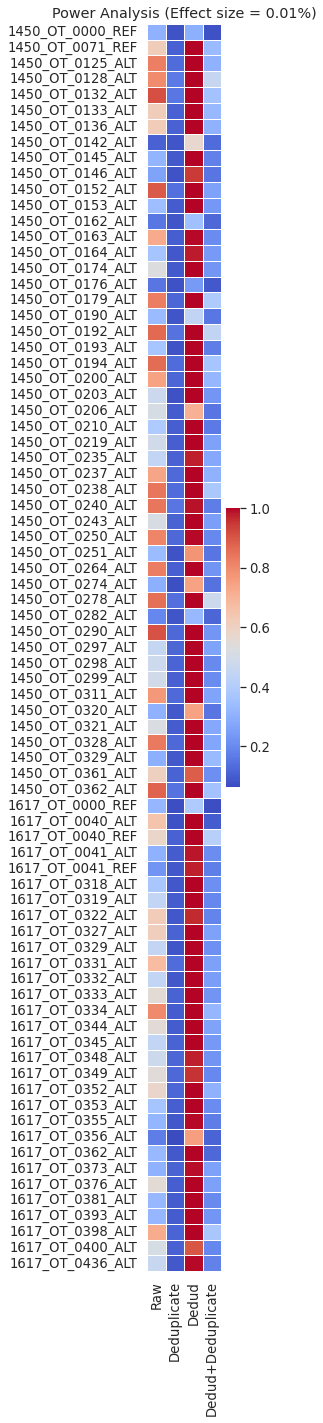

In [397]:
fig, ax = plt.subplots(figsize=(4, 20))
ax = sns.heatmap(all_merge.set_index('target')[['power_raw', 'power_raw_duplicate', 'power_dedud', 'power_dedud_deplicate']], cmap='coolwarm',cbar_kws={'shrink': 0.5}, linewidth=.5, ax=ax)
ax.set(xlabel="", ylabel="", title='Power Analysis (Effect size = 0.01%)')
ax.set_xticklabels(['Raw', 'Deduplicate', 'Dedud', 'Dedud+Deduplicate'])
plt.savefig('./figure_forManuscript/heatmap_powerAnlysis_001es.pdf', bbox_inches = 'tight')
sns.set(font_scale=1.2)
# plt.xticks([0.5, 1.5, 2.5, 3.5], ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS'], rotation=90)
# plt.title('Power Analysis\n(Effect size = 0.01%)', fontsize=12)
plt.tight_layout()

In [428]:
candidate_targets = ['1617_OT_0000_REF', '1617_OT_0041_ALT','1617_OT_0344_ALT','1617_OT_0040_ALT', '1450_OT_0000_REF', '1450_OT_0071_REF', '1450_OT_0274_ALT']
for target in candidate_targets:
    # dedud_dedup_fn = glob.glob('./CRISPRessoBatch_alleles_umi/dedudStringentV3_deduplicateS/results/' + target + '*png')[0]
    dedud_fn = glob.glob('./CRISPRessoBatch_alleles_umi/dedudStringentV3/results/' + target + '*png')[0]
    # Display image in Jupyter Notebook
    image = Image.open(dedud_fn)
    display(image)

In [414]:
margin_conf_res = pd.read_csv('./CRISPRessoBatch_alleles_umi/globalResults_fourStrategies_231214_compare/summaryResultsAllSettingsPowerMarginal', sep='\t')

In [419]:
margin_res = pd.read_csv('./CRISPRessoBatch_alleles_umi/globalResults_raw_dedudStringentV3_effects_compare/summaryResultsAllSettingsPowerMarginal', sep='\t')
margin_res['marginalPredDelta'] = margin_res['marginalPredTrear'] - margin_res['marginalPredCrtl'] 
margin_res['significant'] = (margin_res['adjpvalue'] < 0.05)&(margin_res['marginalPredDelta']>0.1/100)
margin_res_pivot = margin_res.pivot("offtarget", "folder", "significant")

In [427]:
candidate_targets = margin_res_pivot[margin_res_pivot['raw']].index
for target in candidate_targets:
    # dedud_dedup_fn = glob.glob('./CRISPRessoBatch_alleles_umi/dedudStringentV3_deduplicateS/results/' + target + '*png')[0]
    dedud_fn = glob.glob('./CRISPRessoBatch_alleles_umi/raw/results/' + target + '*png')[0]

    # Display image in Jupyter Notebook
    image = Image.open(dedud_fn)
    display(image)

In [484]:
glob.glob('./CRISPRessoBatch_alleles_umi/dedudStringentV3//*1450_OT_0274_ALT*NoEP*')

['./CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S3_D3734_NoEP_T1_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S4_D3734_NoEP_T2_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S5_D3734_NoEP_T3_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S12_D3742_NoEP_T1_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S13_D3742_NoEP_T2_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S14_D3742_NoEP_T3_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S21_D3908_NoEP_T1_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S22_D3908_NoEP_T2_Allele_frequency_table_withUMI.txt',
 './CRISPRe

In [490]:
glob.glob('./CRISPRessoBatch_alleles_umi/dedudStringentV3//*1450_OT_0274_ALT*HiFi*')

['./CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S1_D3734_HiFi_T1_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S2_D3734_HiFi_T2_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S9_D3742_HiFi_T1_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S10_D3742_HiFi_T2_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S11_D3742_HiFi_T3_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S18_D3908_HiFi_T1_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S19_D3908_HiFi_T2_Allele_frequency_table_withUMI.txt',
 './CRISPRessoBatch_alleles_umi/dedudStringentV3/1450_OT_0274_ALT_LV_S20_D3908_HiFi_T3_Allele_frequency_table_withUMI.txt']

In [492]:
T1D1_1450_OT_0274 = pd.read_csv('./CRISPRessoBatch_alleles_umi/raw_withCat/1450_OT_0274_ALT_LV_S1_D3734_HiFi_T1_Allele_frequency_table_withUMI.txt', sep=',')
T1D1_1450_OT_0274 = T1D1_1450_OT_0274[~T1D1_1450_OT_0274['Unedited']].sort_values(by='%Reads', ascending=False)
T2D1_1450_OT_0274 = pd.read_csv('./CRISPRessoBatch_alleles_umi/raw_withCat/1450_OT_0274_ALT_LV_S2_D3734_HiFi_T2_Allele_frequency_table_withUMI.txt', sep=',')
T2D1_1450_OT_0274 = T2D1_1450_OT_0274[~T2D1_1450_OT_0274['Unedited']].sort_values(by='%Reads', ascending=False)

T1D1_1450_OT_0274_noEP = pd.read_csv('./CRISPRessoBatch_alleles_umi/raw_withCat/1450_OT_0274_ALT_LV_S3_D3734_NoEP_T1_Allele_frequency_table_withUMI.txt', sep=',')
T1D1_1450_OT_0274_noEP = T1D1_1450_OT_0274_noEP[~T1D1_1450_OT_0274_noEP['Unedited']].sort_values(by='%Reads', ascending=False)
T2D1_1450_OT_0274_noEP = pd.read_csv('./CRISPRessoBatch_alleles_umi/raw_withCat/1450_OT_0274_ALT_LV_S4_D3734_NoEP_T2_Allele_frequency_table_withUMI.txt', sep=',')
T2D1_1450_OT_0274_noEP = T2D1_1450_OT_0274_noEP[~T2D1_1450_OT_0274_noEP['Unedited']].sort_values(by='%Reads', ascending=False)

In [488]:
sel_cols = ['UMI', 'Aligned_Sequence', 'Reference_Sequence', '#Reads', '%Reads', 'sample_id', 'donor', 'replicate', 'group', 'UMI_maxi_v3']

In [ ]:
# combination figure

In [371]:
margin_res = pd.read_csv('./CRISPRessoBatch_alleles_umi/globalResults_fourStrategies_231214_compare/summaryResultsAllSettingsPowerMarginal', sep='\t', index_col='offtarget')
margin_res['marginalPredDelta'] = margin_res['marginalPredTrear'] - margin_res['marginalPredCrtl'] 
margin_res_dedud = margin_res[margin_res['folder'] == 'dedudStringentV3']
margin_res_dedud = margin_res_dedud[['marginalPredCrtl',
       'marginalPredTrear', 'confLowCtrl', 'confLowTrear', 'confHighCtrl',
       'confHighTrear', 'marginalPredDelta']]
margin_res_dedud = margin_res_dedud*100
margin_res_dedud['errorLowTrear'] = abs(margin_res_dedud['confLowTrear'] - margin_res_dedud['marginalPredTrear'])
margin_res_dedud['errorHighTrear'] = abs(margin_res_dedud['confHighTrear'] - margin_res_dedud['marginalPredTrear'])
margin_res_dedud['errorLowCrtl'] = abs(margin_res_dedud['confLowCtrl'] - margin_res_dedud['marginalPredCrtl'])
margin_res_dedud['errorHighCrtl'] = abs(margin_res_dedud['confHighCtrl'] - margin_res_dedud['marginalPredCrtl'])

In [372]:
# pd.read_csv('./CRISPRessoBatch_alleles_umi/globalResults_fourStrategies_231214_compare/summaryResultsAllSettingsPowerMarginal', sep='\t', index_col='offtarget')

In [383]:
margin_res_dedud['errorLowCrtl'].max()

0.013776605534019992

In [374]:
margin_res_dedud = margin_res_dedud.reset_index()

In [375]:
margin_res_dedud['marginalPredCrtl_rs'] = margin_res_dedud['marginalPredCrtl'] - margin_res_dedud['marginalPredCrtl']
margin_res_dedud['marginalPredTrear_rs'] = margin_res_dedud['marginalPredTrear'] - margin_res_dedud['marginalPredCrtl']

In [385]:
margin_res_dedud['marginalPredTrear_rs'].min()

-0.05485868902148

In [389]:
margin_res_dedud[margin_res_dedud['offtarget'] == '1450_OT_0176_ALT']

,offtarget,marginalPredCrtl,marginalPredTrear,confLowCtrl,confLowTrear,confHighCtrl,confHighTrear,marginalPredDelta,errorLowTrear,errorHighTrear,errorLowCrtl,errorHighCrtl,marginalPredCrtl_rs,marginalPredTrear_rs
16,1450_OT_0176_ALT,0.138682,0.083823,0.124905,0.072347,0.153976,0.097119,-0.054859,0.011477,0.013295,0.013777,0.015294,0.0,-0.054859


In [76]:
%matplotlib notebook

In [77]:
# x = np.arange(0, 1000)

# for name, ax in axs.items():
#     if name in ['asinh', 'symlog']:
#         yy = x - np.mean(x)
#     elif name in ['logit']:
#         yy = (x-np.min(x))
#         yy = yy / np.max(np.abs(yy))
#     else:
#         yy = x

#     ax.plot(yy, yy)
#     ax.set_yscale(name)
#     ax.set_title(name)

<IPython.core.display.Javascript object>


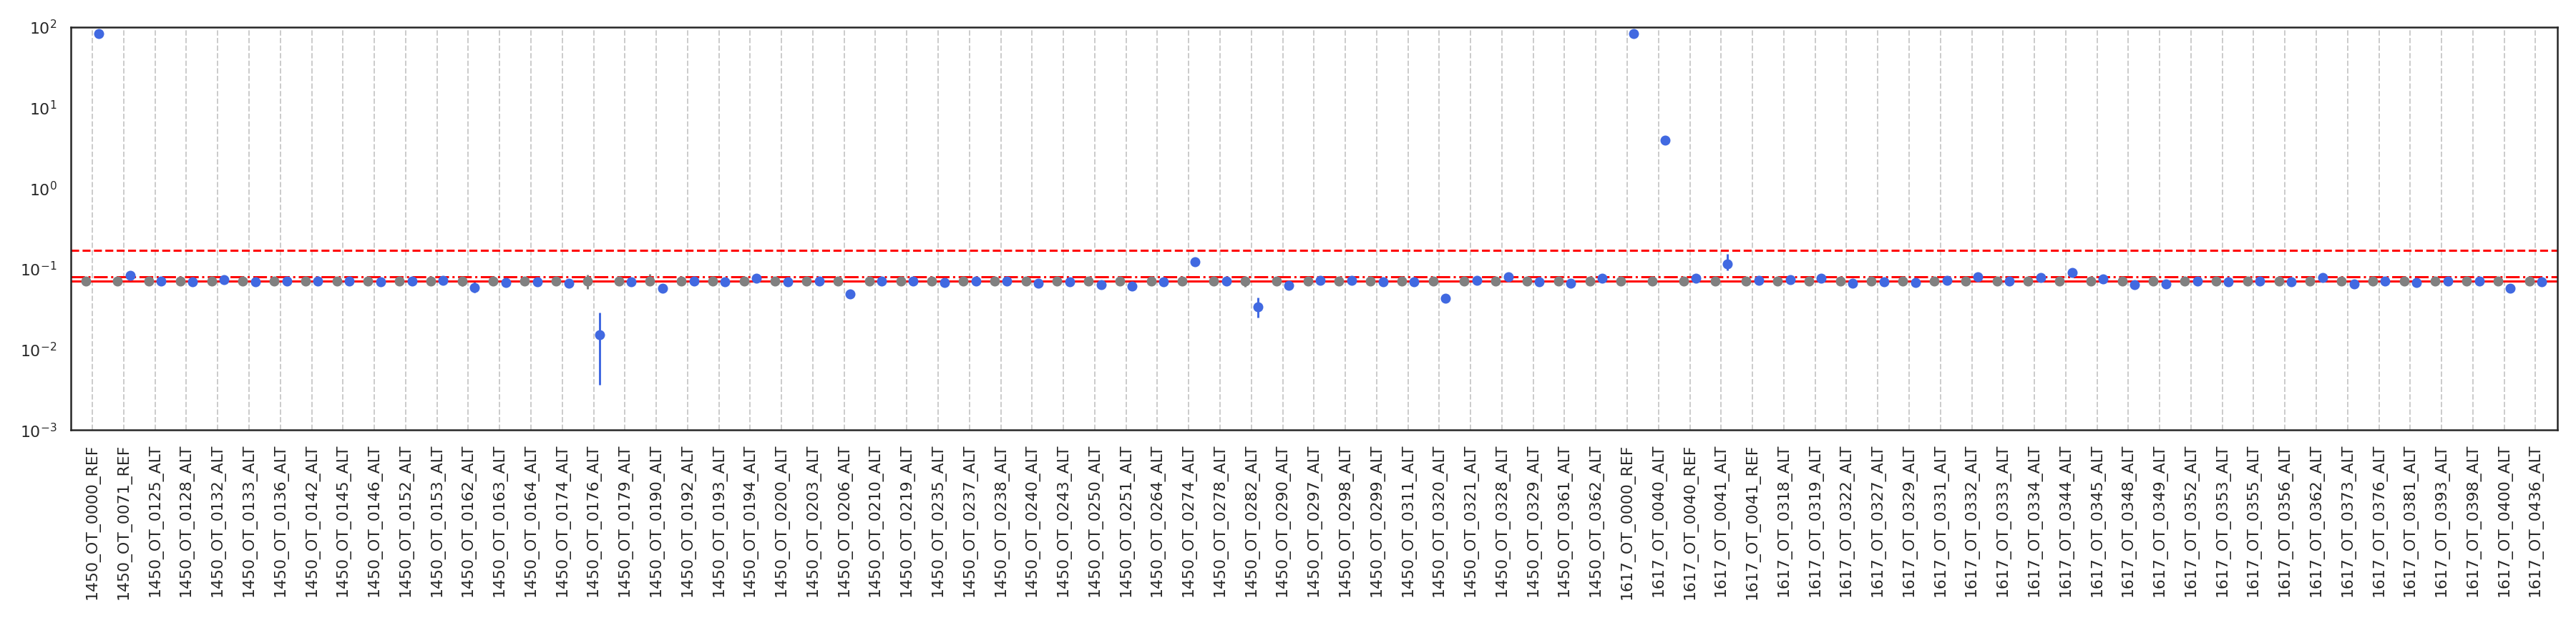

In [396]:
sns.set_theme('notebook')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(25, 6))
plus_t = 0.07
ax.errorbar(x = np.arange(len(margin_res_dedud['offtarget']))+0.2, y = margin_res_dedud['marginalPredTrear_rs']+plus_t, yerr=margin_res_dedud[['errorLowTrear', 'errorHighTrear']].values.T, fmt='o', color='royalblue', label='Edited')
ax.errorbar(x = np.arange(len(margin_res_dedud['offtarget']))-0.2, y = margin_res_dedud['marginalPredCrtl_rs']+plus_t, yerr=margin_res_dedud[['errorLowCrtl', 'errorHighCrtl']].values.T, fmt='o', color='grey', label='Unedited')

plt.xlim(-0.7, len(margin_res_dedud['offtarget'])-0.3)

plt.xticks(ticks=np.arange(len(margin_res_dedud['offtarget'])), labels=margin_res_dedud['offtarget'], rotation='90')
# plt.xticks(ticks=np.arange(len(margin_res_dedud['offtarget'])), labels=['']*len(margin_res_dedud['offtarget']), rotation='90')
# plt.hlines(y=0.2, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='--', color='red')
plt.hlines(y=0.1+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='--', color='red')
plt.hlines(y=0.01+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='-.', color='red')
plt.hlines(y=0.001+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='-', color='red')
# plt.xticks(np.arange(len(margin_res_dedud['offtarget'])), [" "]*len(margin_res_dedud['offtarget']))
plt.grid(axis='x', linestyle='--')
# plt.semilogy()
plt.yscale('log')
plt.ylim(1e-3, 1e2)
# plt.xlabel('Targets')# plt.grid(axis='x')
plt.tight_layout()

In [415]:
margin_res_dedud[['confLowCtrl', 'confLowTrear']].min()

SyntaxError: invalid syntax (<ipython-input-415-db315778824b>, line 1)

<IPython.core.display.Javascript object>


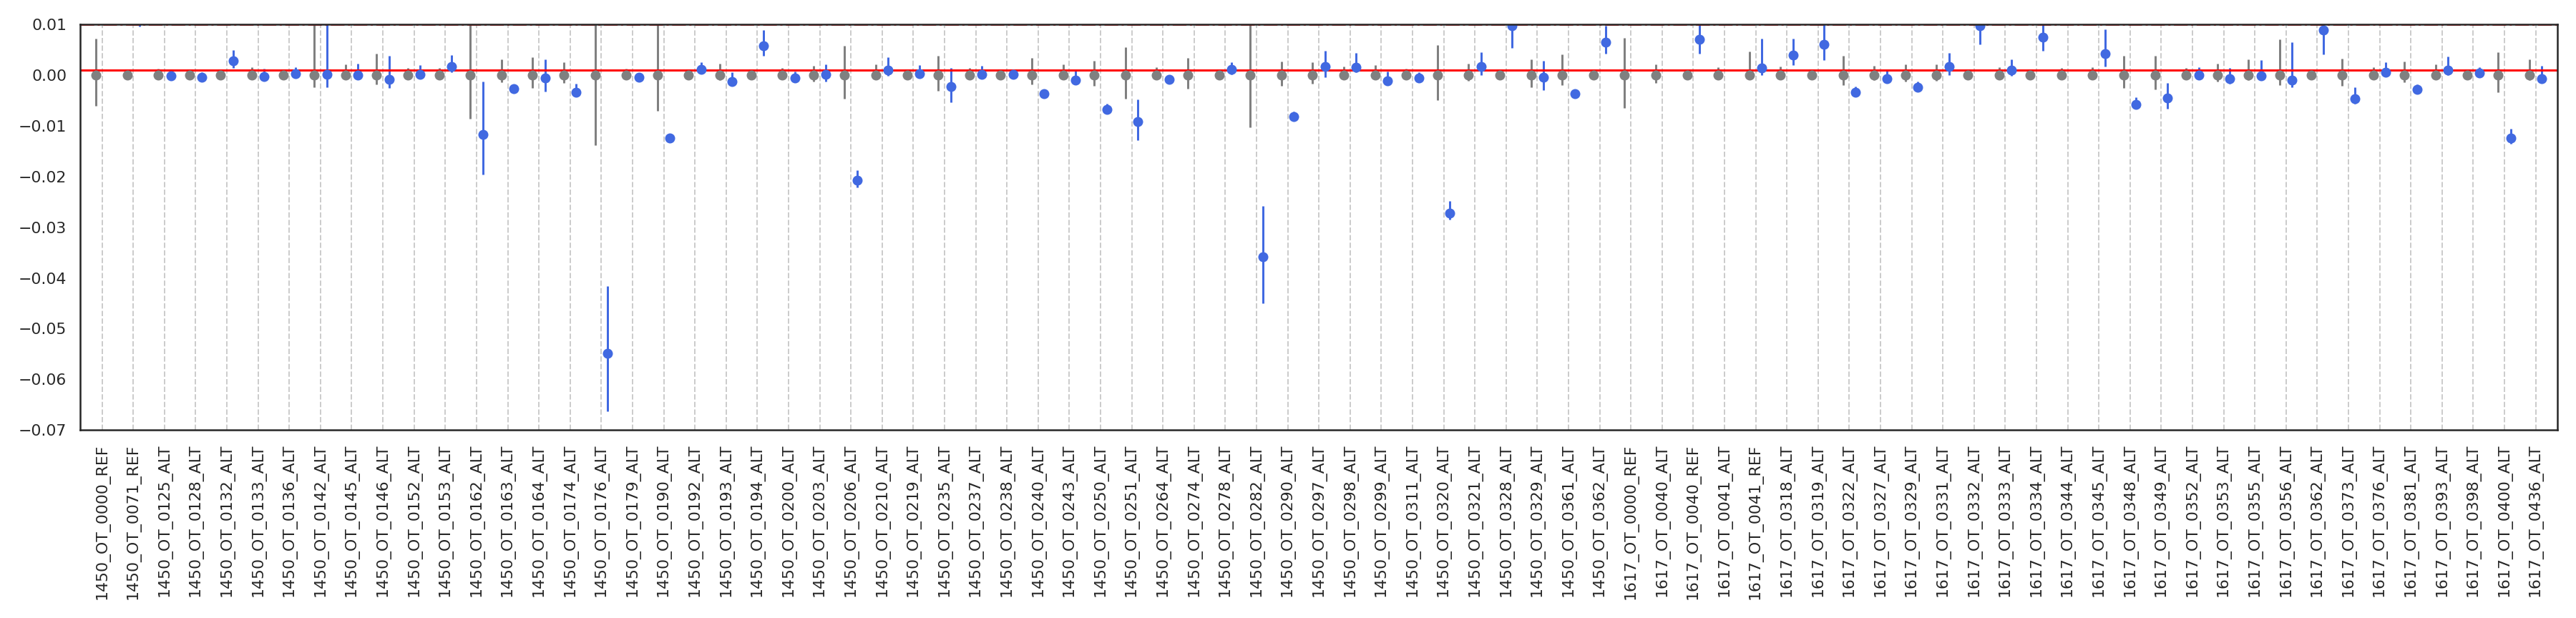

In [428]:
sns.set_theme('notebook')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(25, 6))
plus_t = 0
ax.errorbar(x = np.arange(len(margin_res_dedud['offtarget']))+0.2, y = margin_res_dedud['marginalPredTrear_rs']+plus_t, yerr=margin_res_dedud[['errorLowTrear', 'errorHighTrear']].values.T, fmt='o', color='royalblue', label='Edited')
ax.errorbar(x = np.arange(len(margin_res_dedud['offtarget']))-0.2, y = margin_res_dedud['marginalPredCrtl_rs']+plus_t, yerr=margin_res_dedud[['errorLowCrtl', 'errorHighCrtl']].values.T, fmt='o', color='grey', label='Unedited')

plt.xlim(-0.7, len(margin_res_dedud['offtarget'])-0.3)

plt.xticks(ticks=np.arange(len(margin_res_dedud['offtarget'])), labels=margin_res_dedud['offtarget'], rotation='90')
# plt.xticks(ticks=np.arange(len(margin_res_dedud['offtarget'])), labels=['']*len(margin_res_dedud['offtarget']), rotation='90')
# plt.hlines(y=0.2, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='--', color='red')
plt.hlines(y=0.1+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='--', color='red')
plt.hlines(y=0.01+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='-.', color='red')
plt.hlines(y=0.001+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='-', color='red')
# plt.xticks(np.arange(len(margin_res_dedud['offtarget'])), [" "]*len(margin_res_dedud['offtarget']))
plt.grid(axis='x', linestyle='--')
# plt.semilogy()
plt.ylim(-0.07, 0.01)
# plt.xlabel('Targets')# plt.grid(axis='x')
plt.tight_layout()

In [ ]:
sns.set_theme('notebook')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(25, 6))
plus_t = 0.07
ax.errorbar(x = np.arange(len(margin_res_dedud['offtarget']))+0.2, y = margin_res_dedud['marginalPredTrear_rs']+plus_t, yerr=margin_res_dedud[['errorLowTrear', 'errorHighTrear']].values.T, fmt='o', color='royalblue', label='Edited')
ax.errorbar(x = np.arange(len(margin_res_dedud['offtarget']))-0.2, y = margin_res_dedud['marginalPredCrtl_rs']+plus_t, yerr=margin_res_dedud[['errorLowCrtl', 'errorHighCrtl']].values.T, fmt='o', color='grey', label='Unedited')

plt.xlim(-0.7, len(margin_res_dedud['offtarget'])-0.3)

plt.xticks(ticks=np.arange(len(margin_res_dedud['offtarget'])), labels=margin_res_dedud['offtarget'], rotation='90')
# plt.xticks(ticks=np.arange(len(margin_res_dedud['offtarget'])), labels=['']*len(margin_res_dedud['offtarget']), rotation='90')
# plt.hlines(y=0.2, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='--', color='red')
plt.hlines(y=0.1+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='--', color='red')
plt.hlines(y=0.01+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='-.', color='red')
plt.hlines(y=0.001+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='-', color='red')
# plt.xticks(np.arange(len(margin_res_dedud['offtarget'])), [" "]*len(margin_res_dedud['offtarget']))
plt.grid(axis='x', linestyle='--')
# plt.semilogy()
# plt.ylim(1e-3, 1e2)
# plt.xlabel('Targets')# plt.grid(axis='x')
plt.tight_layout()

In [35]:
# sns.set_theme('notebook')
# sns.set_style('white')
# plt.figure(figsize=(25, 6))
# plus_t = 1
# plt.errorbar(x = np.arange(len(margin_res_dedud['offtarget']))+0.2, y = margin_res_dedud['marginalPredTrear']+plus_t, yerr=margin_res_dedud[['errorLowTrear', 'errorHighTrear']].values.T, fmt='o', color='royalblue', label='Edited')
# plt.errorbar(x = np.arange(len(margin_res_dedud['offtarget']))-0.2, y = margin_res_dedud['marginalPredCrtl']+plus_t, yerr=margin_res_dedud[['errorLowCrtl', 'errorHighCrtl']].values.T, fmt='o', color='grey', label='Unedited')
# plt.yscale('log')
# plt.xlim(-0.7, len(margin_res_dedud['offtarget'])-0.3)

# plt.xticks(ticks=np.arange(len(margin_res_dedud['offtarget'])), labels=margin_res_dedud['offtarget'], rotation='90')
# # plt.xticks(ticks=np.arange(len(margin_res_dedud['offtarget'])), labels=['']*len(margin_res_dedud['offtarget']), rotation='90')
# # plt.hlines(y=0.2, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='--', color='red')
# plt.hlines(y=0.1+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='--', color='red')
# plt.hlines(y=0.01+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='-.', color='red')
# plt.hlines(y=0.001+plus_t, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='-', color='red')
# # plt.xticks(np.arange(len(margin_res_dedud['offtarget'])), [" "]*len(margin_res_dedud['offtarget']))
# plt.grid(axis='x', linestyle='--')
# # plt.xlabel('Targets')# plt.grid(axis='x')
# plt.tight_layout()

In [1163]:
# margin_res_dedud

In [1164]:
%matplotlib inline

In [36]:
margin_res = pd.read_csv('./CRISPRessoBatch_alleles_umi/globalResults_fourStrategies_231214_compare/summaryResultsAllSettingsPowerMarginal', sep='\t', index_col='offtarget')
margin_res['marginalPredDelta'] = margin_res['marginalPredTrear'] - margin_res['marginalPredCrtl'] 
margin_res_dedud = margin_res[margin_res['folder'] == 'dedudStringentV3']
margin_res_dedud = margin_res_dedud[['marginalPredCrtl',
       'marginalPredTrear', 'confLowCtrl', 'confLowTrear', 'confHighCtrl',
       'confHighTrear', 'marginalPredDelta']]
margin_res_dedud = margin_res_dedud*100
margin_res_dedud['errorLowTrear'] = abs(margin_res_dedud['confLowTrear'] - margin_res_dedud['marginalPredTrear'])
margin_res_dedud['errorHighTrear'] = abs(margin_res_dedud['confHighTrear'] - margin_res_dedud['marginalPredTrear'])
margin_res_dedud['errorLowCrtl'] = abs(margin_res_dedud['confLowCtrl'] - margin_res_dedud['marginalPredCrtl'])
margin_res_dedud['errorHighCrtl'] = abs(margin_res_dedud['confHighCtrl'] - margin_res_dedud['marginalPredCrtl'])
margin_res_dedud = margin_res_dedud.reset_index()

<IPython.core.display.Javascript object>


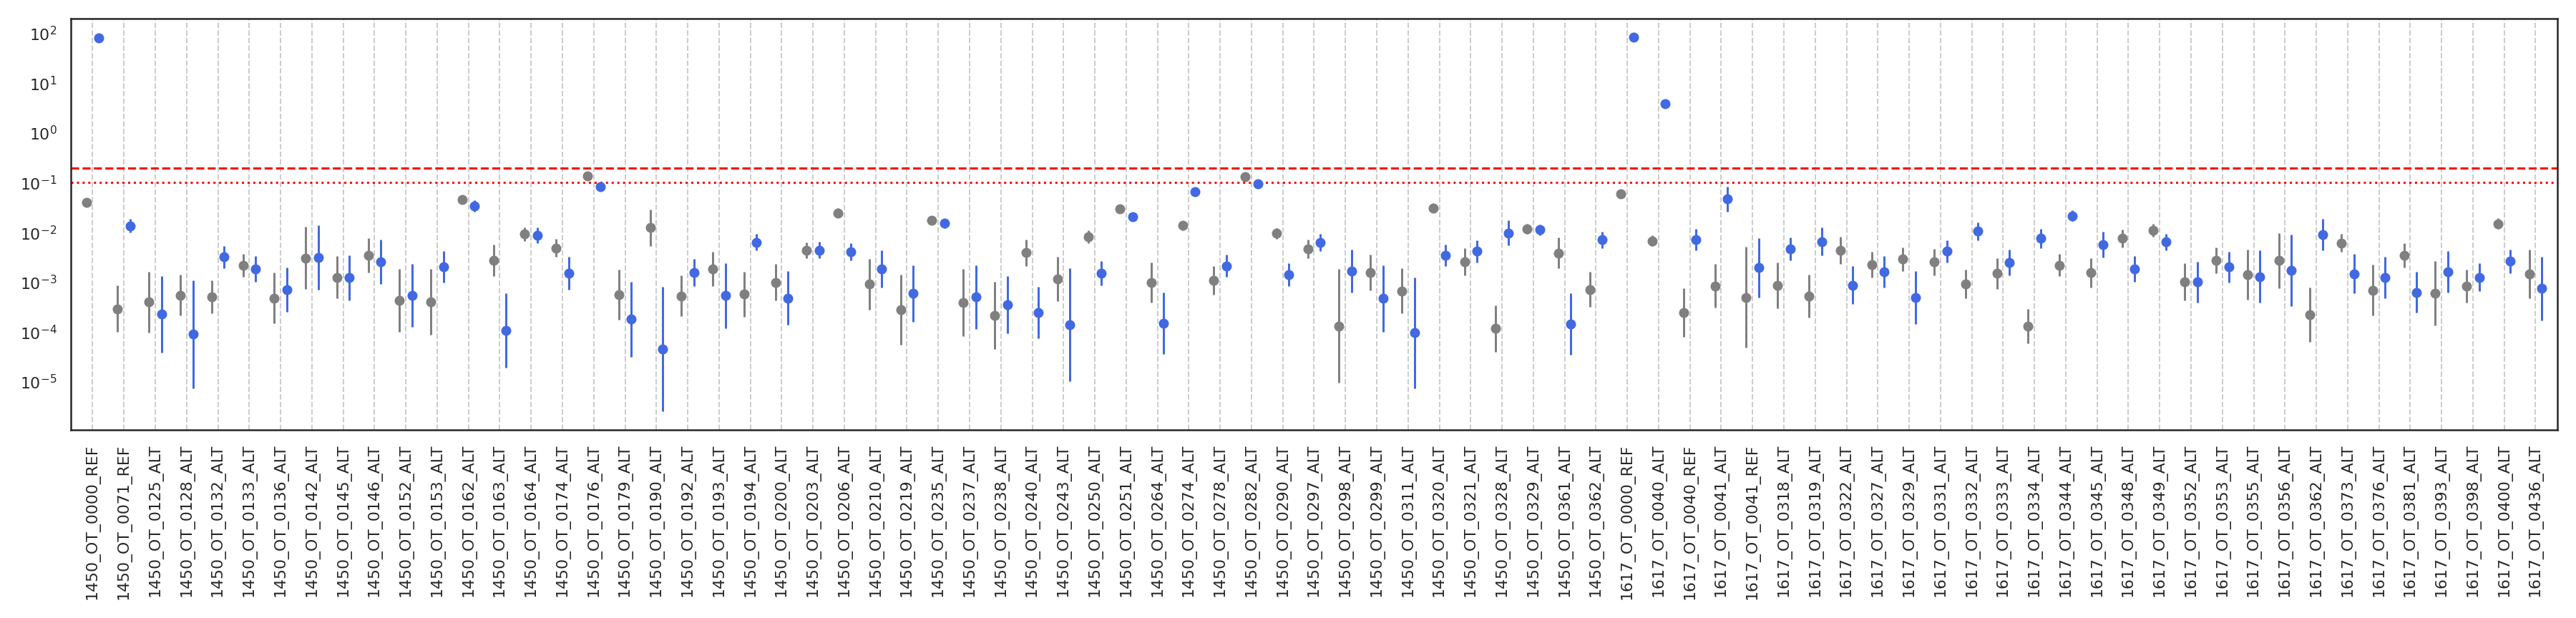

In [38]:
# sns.set_theme('notebook')
# sns.set_style('white')
plt.figure(figsize=(25, 6))
plt.errorbar(x = np.arange(len(margin_res_dedud['offtarget']))+0.2, y = margin_res_dedud['marginalPredTrear'], yerr=margin_res_dedud[['errorLowTrear', 'errorHighTrear']].values.T, fmt='o', color='royalblue', label='Edited')
plt.errorbar(x = np.arange(len(margin_res_dedud['offtarget']))-0.2, y = margin_res_dedud['marginalPredCrtl'], yerr=margin_res_dedud[['errorLowCrtl', 'errorHighCrtl']].values.T, fmt='o', color='grey', label='Unedited')
# plt.yscale('log')
plt.semilogy()
plt.xlim(-0.7, len(margin_res_dedud['offtarget'])-0.3)
plt.xticks(ticks=np.arange(len(margin_res_dedud['offtarget'])), labels=margin_res_dedud['offtarget'], rotation='90')
# plt.xticks(ticks=np.arange(len(margin_res_dedud['offtarget'])), labels=['']*len(margin_res_dedud['offtarget']), rotation='90')
plt.hlines(y=0.2, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles='--', color='red')
plt.hlines(y=0.1, xmin=-0.7, xmax=len(margin_res_dedud['offtarget'])-0.3, linestyles=':', color='red')
# plt.xticks(np.arange(len(margin_res_dedud['offtarget'])), [" "]*len(margin_res_dedud['offtarget']))
plt.grid(axis='x', linestyle='--')
# plt.xlabel('Targets')# plt.grid(axis='x')
plt.tight_layout()

In [265]:
dedudv3_v1 = pd.read_csv('/data/pinello/PROJECTS/2022_04_LVOT/trimmed_fastq_vpooled_all/CRISPRessoBatch_alleles_umi/power_analysis/dedudStringentV3_effectSize0.001.tsv', sep='\t')
dedudv3_v1['effectSize'] = 0.001
dedudv3_v2 = pd.read_csv('/data/pinello/PROJECTS/2022_04_LVOT/trimmed_fastq_vpooled_all/CRISPRessoBatch_alleles_umi/power_analysis/dedudStringentV3.tsv', sep='\t')
dedudv3_v2['effectSize'] = 0.0001

In [267]:
dedudv3_power = dedudv3_v1.merge(dedudv3_v2, on='target', suffixes=['_0.1', '0.01'])

In [268]:
dedudv3_power

,target,power_0.1,type_0.1,effectSize_0.1,power0.01,type0.01,effectSize0.01
0,1450_OT_0000_REF,1,dedudStringentV3,0.001,0.294,dedudStringentV3,0.0001
1,1450_OT_0071_REF,1,dedudStringentV3,0.001,1.000,dedudStringentV3,0.0001
2,1450_OT_0125_ALT,1,dedudStringentV3,0.001,1.000,dedudStringentV3,0.0001
3,1450_OT_0128_ALT,1,dedudStringentV3,0.001,1.000,dedudStringentV3,0.0001
4,1450_OT_0132_ALT,1,dedudStringentV3,0.001,1.000,dedudStringentV3,0.0001
...,...,...,...,...,...,...,...
74,1617_OT_0381_ALT,1,dedudStringentV3,0.001,0.999,dedudStringentV3,0.0001
75,1617_OT_0393_ALT,1,dedudStringentV3,0.001,1.000,dedudStringentV3,0.0001
76,1617_OT_0398_ALT,1,dedudStringentV3,0.001,1.000,dedudStringentV3,0.0001
77,1617_OT_0400_ALT,1,dedudStringentV3,0.001,0.901,dedudStringentV3,0.0001


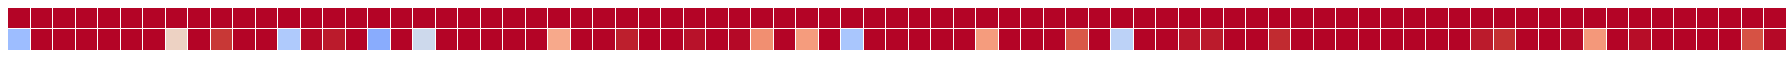

In [1057]:
fig, ax = plt.subplots(figsize=(25, 0.9))
ax = sns.heatmap(dedudv3_power.set_index('target')[['power_0.1', 'power0.01']].T, cmap='coolwarm', cbar=False, linewidth=0.5, ax=ax, yticklabels=['0.1%', '0.01%'], vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.tight_layout()

In [1561]:
margin_res = pd.read_csv('./CRISPRessoBatch_alleles_umi/globalResults_fourStrategies_231214_compare/summaryResultsAllSettingsPowerMarginal', sep='\t', index_col='offtarget')
margin_res['marginalPredDelta'] = margin_res['marginalPredTrear'] - margin_res['marginalPredCrtl'] 
margin_res_dedud = margin_res[margin_res['folder'] == 'dedudStringentV3'].reset_index()
margin_res_raw = margin_res[margin_res['folder'] == 'raw'].reset_index()
margin_res_dedup = margin_res[margin_res['folder'] == 'raw_deduplicateS'].reset_index()
margin_res_dedud_dedup = margin_res[margin_res['folder'] == 'dedudStringentV3_deduplicateS'].reset_index()

In [1562]:
margin_res_dedud['Signficant_L1'] = (margin_res_dedud['adjpvalue'] < 0.05)&(margin_res_dedud['marginalPredDelta'] >0)
margin_res_dedud['Signficant_L2'] = (margin_res_dedud['adjpvalue'] < 0.05)&(margin_res_dedud['marginalPredDelta'] >0.01/100)
margin_res_dedud['Signficant_L3'] = (margin_res_dedud['adjpvalue'] < 0.05)&(margin_res_dedud['marginalPredDelta'] >0.1/100)
margin_res_raw['Signficant_L1'] = (margin_res_raw['adjpvalue'] < 0.05)&(margin_res_raw['marginalPredDelta'] >0)
margin_res_raw['Signficant_L2'] = (margin_res_raw['adjpvalue'] < 0.05)&(margin_res_raw['marginalPredDelta'] >0.01/100)
margin_res_raw['Signficant_L3'] = (margin_res_raw['adjpvalue'] < 0.05)&(margin_res_raw['marginalPredDelta'] >0.1/100)
margin_res_dedup['Signficant_L1'] = (margin_res_dedup['adjpvalue'] < 0.05)&(margin_res_raw['marginalPredDelta'] >0)
margin_res_dedup['Signficant_L2'] = (margin_res_dedup['adjpvalue'] < 0.05)&(margin_res_raw['marginalPredDelta'] >0.01/100)
margin_res_dedup['Signficant_L3'] = (margin_res_dedup['adjpvalue'] < 0.05)&(margin_res_raw['marginalPredDelta'] >0.1/100)
margin_res_dedud_dedup['Signficant_L1'] = (margin_res_dedud_dedup['adjpvalue'] < 0.05)&(margin_res_raw['marginalPredDelta'] >0)
margin_res_dedud_dedup['Signficant_L2'] = (margin_res_dedud_dedup['adjpvalue'] < 0.05)&(margin_res_raw['marginalPredDelta'] >0.01/100)
margin_res_dedud_dedup['Signficant_L3'] = (margin_res_dedud_dedup['adjpvalue'] < 0.05)&(margin_res_raw['marginalPredDelta'] >0.1/100)

<IPython.core.display.Javascript object>


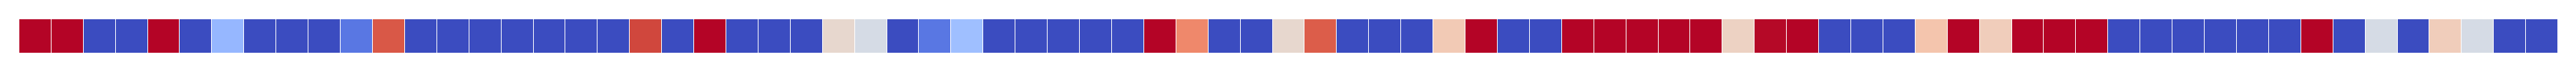

In [1584]:
fig, ax = plt.subplots(figsize=(25, 0.7))
ax = sns.heatmap(margin_res_dedud[['adjpvalue']].T, cmap='coolwarm_r', cbar=False, cbar_kws={'shrink': 0.5}, linewidth=.5, ax=ax)
plt.yticks([])
plt.xticks([])
plt.xlabel('')
# ax.set(xlabel="", ylabel="", title='Power Analysis (Effect size = 0.01%)')
# ax.set_xticklabels(['Raw', 'Deduplicate', 'Dedud', 'Dedud+Deduplicate'])
# plt.savefig('./figure_forManuscript/heatmap_powerAnlysis_001es.pdf', bbox_inches = 'tight')
# sns.set(font_scale=1.2)
# plt.xticks([0.5, 1.5, 2.5, 3.5], ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS'], rotation=90)
# plt.title('Power Analysis\n(Effect size = 0.01%)', fontsize=12)
plt.tight_layout()

In [1433]:
%matplotlib notebook

In [1444]:
%matplotlib inline

In [1453]:
len(margin_res_dedud['Signficant_L1'])

79

In [1566]:
%matplotlib notebook

<IPython.core.display.Javascript object>


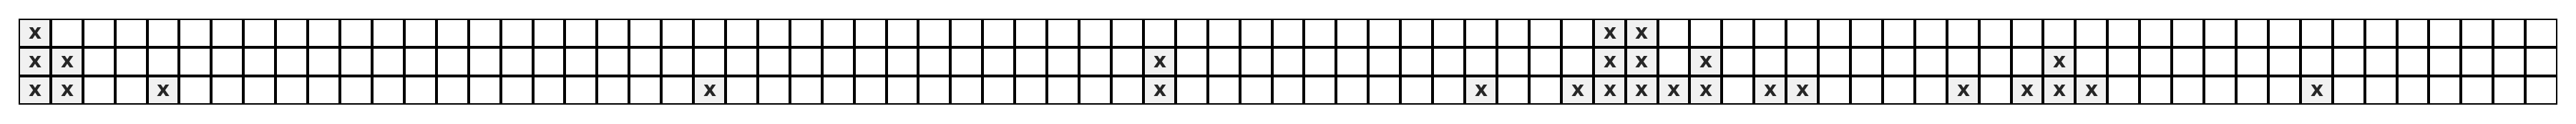

In [1571]:
fig, ax = plt.subplots(figsize=(25, 1.2))
tx = np.array([['']*79, ['']*79, ['']*79])
tx_bool = margin_res_dedud[['Signficant_L3', 'Signficant_L2', 'Signficant_L1']].T.values
for i in range(len(tx_bool)):
    for j in range(len(tx_bool[0])):
        if tx_bool[i,j] == True:
            tx[i,j] = 'x'
        else:
            tx[i,j] = ''
ax = sns.heatmap(margin_res_dedud[['Signficant_L3', 'Signficant_L2','Signficant_L1']].T, annot=tx, fmt='',cbar_kws={'shrink': 0.5}, annot_kws={'size':14, 'fontweight':'bold'}, linecolor = 'black', cmap=sns.light_palette('white', reverse=True, as_cmap=True), cbar=False, linewidth=1.05, ax=ax)
plt.yticks([])
plt.xticks([])
plt.xlabel('')
# ax.set(xlabel="", ylabel="", title='Power Analysis (Effect size = 0.01%)')
# ax.set_xticklabels(['Raw', 'Deduplicate', 'Dedud', 'Dedud+Deduplicate'])
# plt.savefig('./figure_forManuscript/heatmap_powerAnlysis_001es.pdf', bbox_inches = 'tight')
# sns.set(font_scale=1.2)
# plt.xticks([0.5, 1.5, 2.5, f3.5], ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS'], rotation=90)
# plt.title('Power Analysis\n(Effect size = 0.01%)', fontsize=12)
plt.tight_layout()

Raw


<IPython.core.display.Javascript object>


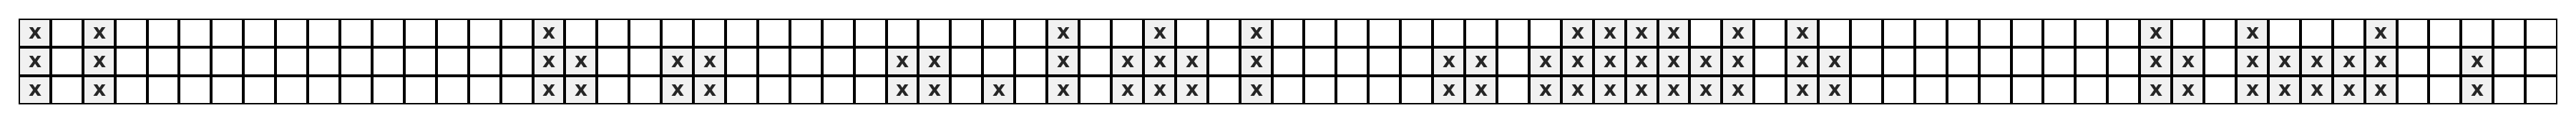

In [1589]:
print('Raw')
fig, ax = plt.subplots(figsize=(25, 1.2))
tx = np.array([['']*79, ['']*79, ['']*79])
tx_bool = margin_res_raw[['Signficant_L3', 'Signficant_L2', 'Signficant_L1']].T.values
for i in range(len(tx_bool)):
    for j in range(len(tx_bool[0])):
        if tx_bool[i,j] == True:
            tx[i,j] = 'x'
        else:
            tx[i,j] = ''
ax = sns.heatmap(margin_res_raw[['Signficant_L3', 'Signficant_L2','Signficant_L1']].T, annot=tx, fmt='',cbar_kws={'shrink': 0.5},annot_kws={'size':14, 'fontweight':'bold'}, linecolor = 'black', cmap=sns.light_palette('white', reverse=True, as_cmap=True), cbar=False, linewidth=1.05, ax=ax)
plt.yticks([])
plt.xticks([])
plt.xlabel('')
# ax.set(xlabel="", ylabel="", title='Power Analysis (Effect size = 0.01%)')
# ax.set_xticklabels(['Raw', 'Deduplicate', 'Dedud', 'Dedud+Deduplicate'])
# plt.savefig('./figure_forManuscript/heatmap_powerAnlysis_001es.pdf', bbox_inches = 'tight')
# sns.set(font_scale=1.2)
# plt.xticks([0.5, 1.5, 2.5, 3.5], ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS'], rotation=90)
# plt.title('Power Analysis\n(Effect size = 0.01%)', fontsize=12)
plt.tight_layout()

Raw+deduplicate


<IPython.core.display.Javascript object>


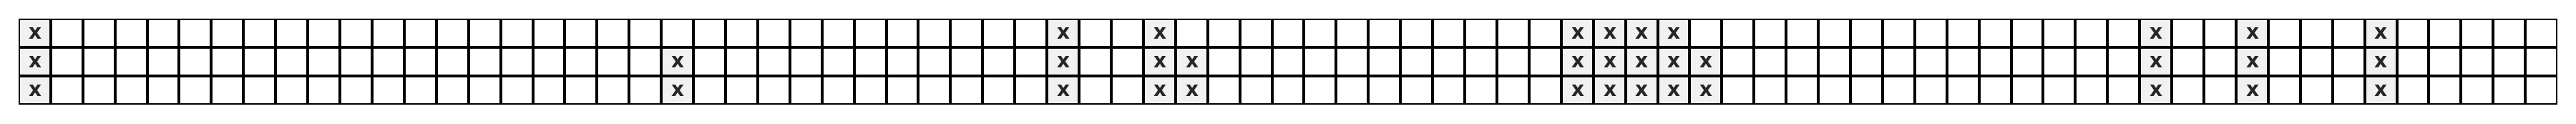

In [1573]:
print('Raw+deduplicate')
fig, ax = plt.subplots(figsize=(25, 1.2))
tx = np.array([['']*79, ['']*79, ['']*79])
tx_bool = margin_res_dedup[['Signficant_L3', 'Signficant_L2', 'Signficant_L1']].T.values
for i in range(len(tx_bool)):
    for j in range(len(tx_bool[0])):
        if tx_bool[i,j] == True:
            tx[i,j] = 'x'
        else:
            tx[i,j] = ''
ax = sns.heatmap(margin_res_dedup[['Signficant_L3', 'Signficant_L2','Signficant_L1']].T, annot=tx, fmt='',cbar_kws={'shrink': 0.5},annot_kws={'size':14, 'fontweight':'bold'}, linecolor = 'black', cmap=sns.light_palette('white', reverse=True, as_cmap=True), cbar=False, linewidth=1.05, ax=ax)

# ax = sns.heatmap(margin_res_dedup[['Signficant_L1', 'Signficant_L2','Signficant_L3']].T, cmap=sns.color_palette("light:r", as_cmap=True), cbar=False, cbar_kws={'shrink': 0.5}, linewidth=.5, ax=ax)

plt.yticks([])
plt.xticks([])
plt.xlabel('')
# ax.set(xlabel="", ylabel="", title='Power Analysis (Effect size = 0.01%)')
# ax.set_xticklabels(['Raw', 'Deduplicate', 'Dedud', 'Dedud+Deduplicate'])
# plt.savefig('./figure_forManuscript/heatmap_powerAnlysis_001es.pdf', bbox_inches = 'tight')
# sns.set(font_scale=1.2)
# plt.xticks([0.5, 1.5, 2.5, 3.5], ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS'], rotation=90)
# plt.title('Power Analysis\n(Effect size = 0.01%)', fontsize=12)
plt.tight_layout()

Dedud+deduplicate


<IPython.core.display.Javascript object>


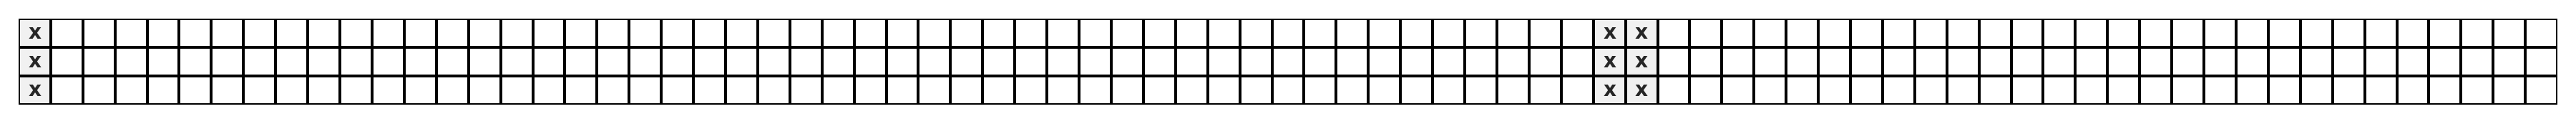

In [1574]:
print('Dedud+deduplicate')
fig, ax = plt.subplots(figsize=(25, 1.2))
tx = np.array([['']*79, ['']*79, ['']*79])
tx_bool = margin_res_dedud_dedup[['Signficant_L3', 'Signficant_L2', 'Signficant_L1']].T.values
for i in range(len(tx_bool)):
    for j in range(len(tx_bool[0])):
        if tx_bool[i,j] == True:
            tx[i,j] = 'x'
        else:
            tx[i,j] = ''
ax = sns.heatmap(margin_res_dedud_dedup[['Signficant_L3', 'Signficant_L2','Signficant_L1']].T,cbar_kws={'shrink': 0.5}, annot=tx, fmt='',annot_kws={'size':14, 'fontweight':'bold'}, linecolor = 'black', cmap=sns.light_palette('white', reverse=True, as_cmap=True), cbar=False, linewidth=1.05, ax=ax)

# ax = sns.heatmap(margin_res_dedud_dedup[['Signficant_L1', 'Signficant_L2','Signficant_L3']].T, cmap='coolwarm', cbar=False, cbar_kws={'shrink': 0.5}, linewidth=.5, ax=ax)
plt.yticks([])
plt.xticks([])
plt.xlabel('')
# ax.set(xlabel="", ylabel="", title='Power Analysis (Effect size = 0.01%)')
# ax.set_xticklabels(['Raw', 'Deduplicate', 'Dedud', 'Dedud+Deduplicate'])
# plt.savefig('./figure_forManuscript/heatmap_powerAnlysis_001es.pdf', bbox_inches = 'tight')
# sns.set(font_scale=1.2)
# plt.xticks([0.5, 1.5, 2.5, 3.5], ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS'], rotation=90)
# plt.title('Power Analysis\n(Effect size = 0.01%)', fontsize=12)
plt.tight_layout()

In [416]:
# candidate_targets = ['1617_OT_0000_REF', '1617_OT_0040_ALT', '1450_OT_0000_REF',]
# for target in candidate_targets:
#     # dedud_dedup_fn = glob.glob('./CRISPRessoBatch_alleles_umi/dedudStringentV3_deduplicateS/results/' + target + '*png')[0]
#     dedud_fn = glob.glob('./CRISPRessoBatch_alleles_umi/dedudStringentV3/results/' + target + '*png')[0]
#     # Display image in Jupyter Notebook
#     image = Image.open(dedud_fn)
#     display(image)

# Comparison scatter plot for four flitering strategies

In [61]:
heatmap_EST_noEP_list = []
heatmap_EST_HiFi_list = []
heatmap_SIG_HiFi_list = []
heatmap_CI_NoEP_list = []
heatmap_CI_HiFi_list = []
all_df_list = []
ds_size = ''
for n in ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS']:
    print(n)
    target_res_list = []
    for fn in glob.glob('././CRISPRessoBatch_alleles_umi/' + n + '/results/*'):
        if not fn.endswith('.png'):
            df = pd.read_csv(fn, sep='\t')
            df['Target'] = fn.split('/')[-1]
            target_res_list.append(df)
    danlio_res_df = pd.concat(target_res_list)
    danlio_res_df['conf.interval'] = danlio_res_df['conf.high'] - danlio_res_df['conf.low']
    danlio_res_df['name'] = danlio_res_df['Target'] + '-' + danlio_res_df['Donor'] + '-' + danlio_res_df['Treat']
    danlio_res_df['filtering_strategy'] = n
    all_df_list.append(danlio_res_df)
    noEP_res_df = danlio_res_df[danlio_res_df['Treat'] == 'NoEP']
    hifi_res_df = danlio_res_df[danlio_res_df['Treat'] == 'HiFi']
    noEP_res_dedup_df = noEP_res_df.drop_duplicates(subset='name')
    hifi_res_dedup_df = hifi_res_df.drop_duplicates(subset='name')
    
    heatmap_hifi_df = hifi_res_dedup_df.pivot("Target", "Donor", "predicted")
    hifi_res_dedup_df['Significant'] = (hifi_res_dedup_df['pvalueTreatPval'] < 0.05)&(hifi_res_dedup_df['pvalueTreatEst']>0)
    heatmap_hifi_sig_df = hifi_res_dedup_df.pivot("Target", "Donor", "Significant")
    heatmap_noEP_df = noEP_res_dedup_df.pivot("Target", "Donor", "predicted")
    for di in ['D3734', 'D3742', 'D3908']:
        heatmap_noEP_df = heatmap_noEP_df.rename(columns={di:di+'_'+n})
        heatmap_hifi_df = heatmap_hifi_df.rename(columns={di:di+'_'+n})
        heatmap_hifi_sig_df = heatmap_hifi_sig_df.rename(columns={di:di+'_'+n})
    heatmap_SIG_HiFi_list.append(heatmap_hifi_sig_df)
    heatmap_EST_HiFi_list.append(heatmap_hifi_df)
    heatmap_EST_noEP_list.append(heatmap_noEP_df)
    
    heatmap_hifi_df = hifi_res_dedup_df.pivot("Target", "Donor", "conf.interval")
    heatmap_noEP_df = noEP_res_dedup_df.pivot("Target", "Donor", "conf.interval")
    for di in ['D3734', 'D3742', 'D3908']:
        heatmap_noEP_df = heatmap_noEP_df.rename(columns={di:di+'_'+n})
        heatmap_hifi_df = heatmap_hifi_df.rename(columns={di:di+'_'+n})
    heatmap_CI_NoEP_list.append(heatmap_noEP_df)
    heatmap_CI_HiFi_list.append(heatmap_hifi_df)
    
all_df = pd.concat(all_df_list)
heatmap_EST_merged_noEP_df = pd.concat(heatmap_EST_noEP_list, axis=1)
heatmap_SIG_merged_HiFi_df = pd.concat(heatmap_SIG_HiFi_list, axis=1)
heatmap_EST_merged_HiFi_df = pd.concat(heatmap_EST_HiFi_list, axis=1)
heatmap_CI_merged_NoEP_df = pd.concat(heatmap_CI_NoEP_list, axis=1)
heatmap_CI_merged_HiFi_df = pd.concat(heatmap_CI_HiFi_list, axis=1)
# heatmap_EST_delta_df = heatmap_EST_merged_HiFi_df - heatmap_EST_merged_noEP_df
# heatmap_EST_merged_sig_df = heatmap_EST_delta_df> 0.1/100
all_df = pd.concat(all_df_list)

raw


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


raw_deduplicateS


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dedudStringentV3


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dedudStringentV3_deduplicateS


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
all_df['donor_con'] = all_df['Donor'] + '-' + all_df['Treat']
all_df['ys'] = all_df['ys']*100
all_df['predicted'] = all_df['predicted']*100
all_df['conf.low'] = all_df['conf.low']*100
all_df['conf.high'] = all_df['conf.high']*100
all_df['errorBarUpper'] = abs(all_df['predicted']-all_df['conf.high'])
all_df['errorBarLower'] = abs(all_df['predicted']-all_df['conf.low'])
all_df['sample_id'] = all_df['name'] + '-' + all_df['S']

In [63]:
HiFi_df=all_df[all_df['Treat'] =='HiFi'].reset_index()
NoEP_df=all_df[all_df['Treat'] =='NoEP'].reset_index()

In [1283]:
# def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
#                      edgecolor='none', alpha=0.5):

#     # Loop over data points; create box from errors at each point
#     errorboxes = [Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
#                   for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

#     # Create patch collection with specified colour/alpha
#     pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
#                          edgecolor=edgecolor)

#     # Add collection to axes
#     ax.add_collection(pc)

#     # Plot errorbars
#     artists = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror,
#                           fmt='none', ecolor='k')

#     return artists

In [1295]:
sns.set_theme('notebook')
sns.set_style('white')

In [64]:
margin_res = pd.read_csv('./CRISPRessoBatch_alleles_umi/globalResults_fourStrategies_231214_compare/summaryResultsAllSettingsPowerMarginal', sep='\t')
margin_res['marginalPredTrear'] = margin_res['marginalPredTrear']*100
margin_res['marginalPredCrtl'] = margin_res['marginalPredCrtl'] *100
margin_res['marginalPredDelta'] = margin_res['marginalPredTrear'] - margin_res['marginalPredCrtl']

In [65]:
def make_compare_scatter(locus, save_folder = None):
    sorder = ['D3734-HiFi', 'D3734-NoEP', 'D3908-HiFi', 'D3908-NoEP', 'D3742-HiFi', 'D3742-NoEP']
    offset = 0.1
    x_id_dict = {'D3734-HiFi':0+offset, 'D3734-NoEP':0-offset, 'D3908-HiFi':1+offset, 'D3908-NoEP':1-offset, 'D3742-HiFi':2+offset, 'D3742-NoEP':2-offset}
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(7.5, 4))
    f.suptitle(locus)
    plt.yscale('log')
    loucs_df = all_df[all_df['Target'] == locus]
    locus_margin_df = margin_res[margin_res['offtarget'] == locus]
    ylow = min(loucs_df['conf.low'])
    yhigh = max(loucs_df['conf.high'])
    plt.ylim(bottom=ylow/2, top=yhigh*2)
    
    filterS = 'dedudStringentV3'
    margin_pv = locus_margin_df[locus_margin_df['folder'] == filterS]['adjpvalue'].values[0]
    margin_delta = locus_margin_df[locus_margin_df['folder'] == filterS]['marginalPredDelta'].values[0] 
    margin_pred_crtl = locus_margin_df[locus_margin_df['folder'] == filterS]['marginalPredCrtl'].values[0]
    margin_pred_trear = locus_margin_df[locus_margin_df['folder'] == filterS]['marginalPredTrear'].values[0]
    title_str = r'%$\Delta$Editing: ' + str(np.round(margin_delta, 2)) + '\nadj-pvalue: ' + str(np.format_float_scientific(np.round(margin_pv,2), exp_digits=2))
    filter_df = all_df[(all_df['Target'] == locus)&((all_df['filtering_strategy'] == filterS))].set_index('donor_con').loc[sorder].reset_index()
    HiFi_df = filter_df[filter_df['Treat'] == 'HiFi']
    NoEP_df = filter_df[filter_df['Treat'] == 'NoEP']
    xticks_t = []
    for idx, row in NoEP_df.iterrows():
        xticks_t.append(x_id_dict[row['donor_con']])
    ax3.errorbar(x = xticks_t, y = NoEP_df['predicted'], yerr=NoEP_df[['errorBarLower', 'errorBarUpper']].values.T, fmt='o', color='grey')
    ax3.scatter(x=xticks_t, y=NoEP_df['ys'], color='black', marker='+')
    xticks_t = []
    for idx, row in HiFi_df.iterrows():
        xticks_t.append(x_id_dict[row['donor_con']])
    ax3.errorbar(x = xticks_t, y = HiFi_df['predicted'], yerr=HiFi_df[['errorBarLower', 'errorBarUpper']].values.T,  fmt='o', color='royalblue')
    ax3.scatter(x=xticks_t, y=HiFi_df['ys'], color='black', marker='+')
    ax3.set_xticks([0, 1, 2])
    ax3.set_xticklabels(['D1', 'D2', 'D3'])
    ax3.set_title("DEDUD\n" + title_str)
    ax3.axhline(y=margin_pred_crtl, color="r", linestyle="-")
    ax3.axhline(y=margin_pred_crtl+0.01, color="r", linestyle="-.")
    ax3.axhline(y=margin_pred_crtl+0.1, color="r", linestyle="--")

    filterS = 'raw'
    margin_pred_crtl = locus_margin_df[locus_margin_df['folder'] == filterS]['marginalPredCrtl'].values[0]
    margin_pv = locus_margin_df[locus_margin_df['folder'] == filterS]['adjpvalue'].values[0]
    margin_delta = locus_margin_df[locus_margin_df['folder'] == filterS]['marginalPredDelta'].values[0]
    title_str = r'%$\Delta$Editing: ' + str(np.round(margin_delta, 2)) + '\nadj-pvalue: ' + str(np.format_float_scientific(np.round(margin_pv,2), exp_digits=2))
    filter_df = all_df[(all_df['Target'] == locus)&((all_df['filtering_strategy'] == filterS))].set_index('donor_con').loc[sorder].reset_index()
    HiFi_df = filter_df[filter_df['Treat'] == 'HiFi']
    NoEP_df = filter_df[filter_df['Treat'] == 'NoEP']
    xticks_t = []
    for idx, row in NoEP_df.iterrows():
        xticks_t.append(x_id_dict[row['donor_con']])
    ax1.errorbar(x = xticks_t, y = NoEP_df['predicted'], yerr=NoEP_df[['errorBarLower', 'errorBarUpper']].values.T, fmt='o', color='grey')
    ax1.scatter(x=xticks_t, y=NoEP_df['ys'], color='black', marker='+')
    ax1.axhline(y=margin_pred_crtl, color="r", linestyle="-")
    ax1.axhline(y=margin_pred_crtl+0.01, color="r", linestyle="-.")
    ax1.axhline(y=margin_pred_crtl+0.1, color="r", linestyle="--")
    xticks_t = []
    for idx, row in HiFi_df.iterrows():
        xticks_t.append(x_id_dict[row['donor_con']])
    ax1.errorbar(x = xticks_t, y = HiFi_df['predicted'], yerr=HiFi_df[['errorBarLower', 'errorBarUpper']].values.T,  fmt='o', color='royalblue')
    ax1.scatter(x=xticks_t, y=HiFi_df['ys'], color='black', marker='+')
    ax1.set_xticks([0, 1, 2])
    ax1.set_xticklabels(['D1', 'D2', 'D3'])
    # ax1.set_yticks([10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1, 10,  100])
    # ax1.set_yticklabels([r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', '1', '10', '100'])
    ax1.set_title("RAW\n"+ title_str)

    filterS = 'raw_deduplicateS'
    margin_pv = locus_margin_df[locus_margin_df['folder'] == filterS]['adjpvalue'].values[0]
    margin_delta = locus_margin_df[locus_margin_df['folder'] == filterS]['marginalPredDelta'].values[0]
    margin_pred_crtl = locus_margin_df[locus_margin_df['folder'] == filterS]['marginalPredCrtl'].values[0]
    title_str = r'%$\Delta$Editing: ' + str(np.round(margin_delta, 2)) + '\nadj-pvalue: ' + str(np.format_float_scientific(np.round(margin_pv,2), exp_digits=2))
    filter_df = all_df[(all_df['Target'] == locus)&((all_df['filtering_strategy'] == filterS))].set_index('donor_con').loc[sorder].reset_index()
    HiFi_df = filter_df[filter_df['Treat'] == 'HiFi']
    NoEP_df = filter_df[filter_df['Treat'] == 'NoEP']
    xticks_t = []
    for idx, row in NoEP_df.iterrows():
        xticks_t.append(x_id_dict[row['donor_con']])
    ax2.errorbar(x = xticks_t, y = NoEP_df['predicted'], yerr=NoEP_df[['errorBarLower', 'errorBarUpper']].values.T, fmt='o', color='grey')
    ax2.scatter(x=xticks_t, y=NoEP_df['ys'], color='black', marker='+')
    xticks_t = []
    for idx, row in HiFi_df.iterrows():
        xticks_t.append(x_id_dict[row['donor_con']])
    ax2.errorbar(x = xticks_t, y = HiFi_df['predicted'], yerr=HiFi_df[['errorBarLower', 'errorBarUpper']].values.T, fmt='o', color='royalblue')
    ax2.scatter(x=xticks_t, y=HiFi_df['ys'], color='black', marker='+')
    ax2.set_xticks([0, 1, 2])
    ax2.set_xticklabels(['D1', 'D2', 'D3'])
    ax2.set_title("DEDUPLICATE\n"+ title_str)
    ax2.axhline(y=margin_pred_crtl, color="r", linestyle="-")
    ax2.axhline(y=margin_pred_crtl+0.01, color="r", linestyle="-.")
    ax2.axhline(y=margin_pred_crtl+0.1, color="r", linestyle="--")

    
    filterS = 'dedudStringentV3_deduplicateS'
    margin_pv = locus_margin_df[locus_margin_df['folder'] == filterS]['adjpvalue'].values[0]
    margin_delta = locus_margin_df[locus_margin_df['folder'] == filterS]['marginalPredDelta'].values[0]
    margin_pred_crtl = locus_margin_df[locus_margin_df['folder'] == filterS]['marginalPredCrtl'].values[0]
    title_str = r'%$\Delta$Editing:' + str(np.round(margin_delta, 2)) + '\nadj-pvalue: ' + str(np.format_float_scientific(np.round(margin_pv,2), exp_digits=2))
    filter_df = all_df[(all_df['Target'] == locus)&((all_df['filtering_strategy'] == filterS))].set_index('donor_con').loc[sorder].reset_index()
    HiFi_df = filter_df[filter_df['Treat'] == 'HiFi']
    NoEP_df = filter_df[filter_df['Treat'] == 'NoEP']
    xticks_t = []
    for idx, row in NoEP_df.iterrows():
        xticks_t.append(x_id_dict[row['donor_con']])
    ax4.errorbar(x = xticks_t, y = NoEP_df['predicted'], yerr=NoEP_df[['errorBarLower', 'errorBarUpper']].values.T, fmt='o', color='grey')
    ax4.scatter(x=xticks_t, y=NoEP_df['ys'], color='black', marker='+')
    xticks_t = []
    for idx, row in HiFi_df.iterrows():
        xticks_t.append(x_id_dict[row['donor_con']])
    ax4.errorbar(x = xticks_t, y = HiFi_df['predicted'], yerr=HiFi_df[['errorBarLower', 'errorBarUpper']].values.T, fmt='o', color='royalblue')
    ax4.scatter(x=xticks_t, y=HiFi_df['ys'], color='black', marker='+')
    ax4.set_xticks([0, 1, 2])
    ax4.set_xticklabels(['D1', 'D2', 'D3'])
    ax4.set_title("DEDUD+DEDUPLICATE\n"+ title_str)
    ax4.axhline(y=margin_pred_crtl, color="r", linestyle="-")
    ax4.axhline(y=margin_pred_crtl+0.01, color="r", linestyle="-.")
    ax4.axhline(y=margin_pred_crtl+0.1, color="r", linestyle="--")

    ax1.grid(linestyle='--')
    ax2.grid(linestyle='--')
    ax3.grid(linestyle='--')
    ax4.grid(linestyle='--')
    
    plt.tight_layout()
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        plt.savefig(save_folder + '/{}.pdf'.format(locus))

<IPython.core.display.Javascript object>


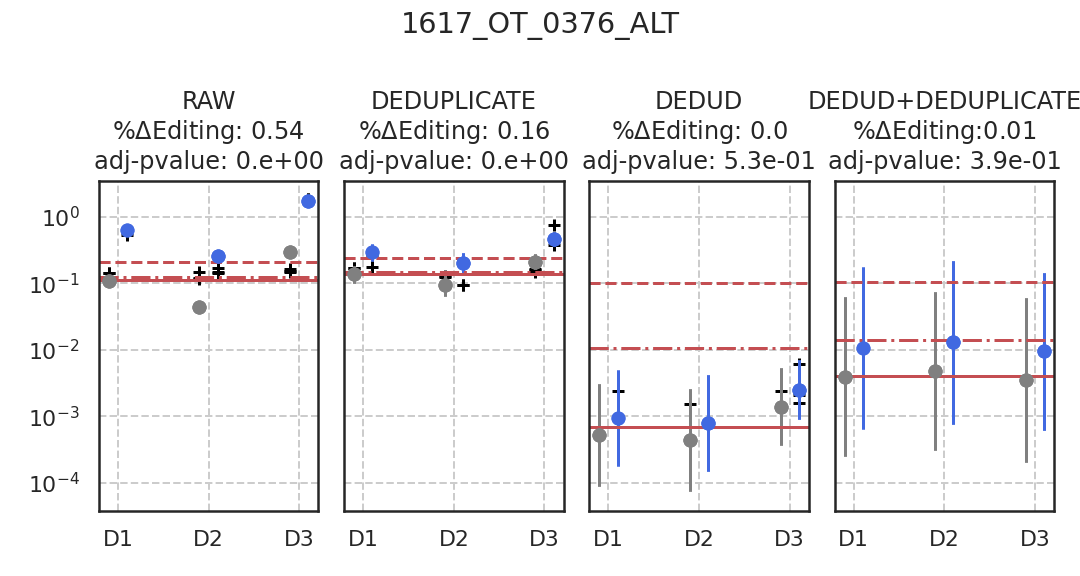

In [66]:
make_compare_scatter('1617_OT_0376_ALT')

In [67]:
%matplotlib inline

In [68]:
off_list = list(margin_res[(margin_res['folder'] == 'raw')&(margin_res['marginalPredDelta'] > 0.1)]['offtarget'])

In [69]:
len(off_list)

15

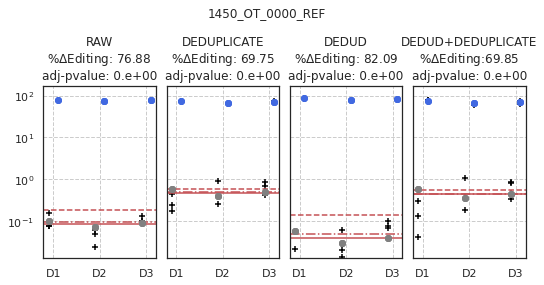

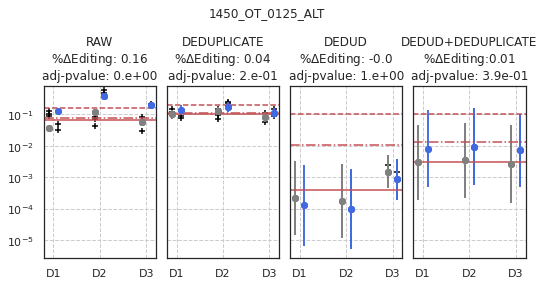

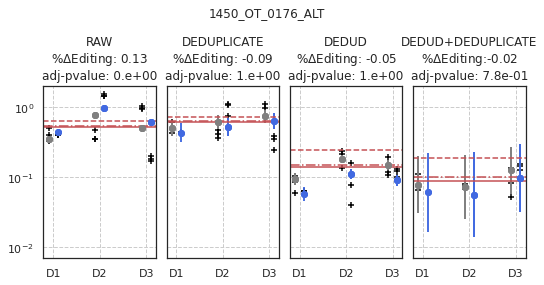

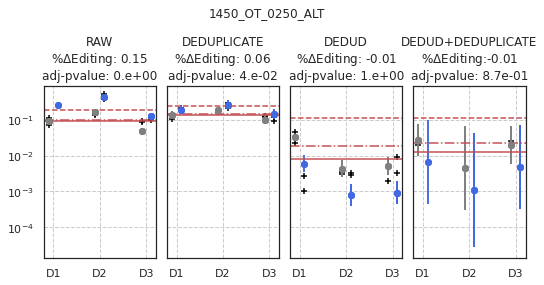

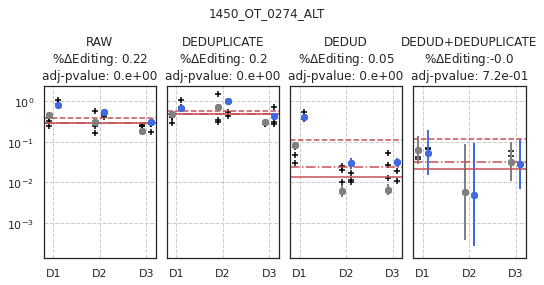

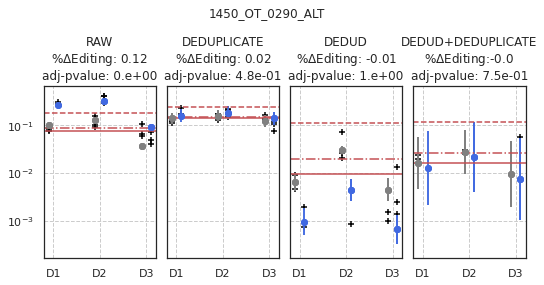

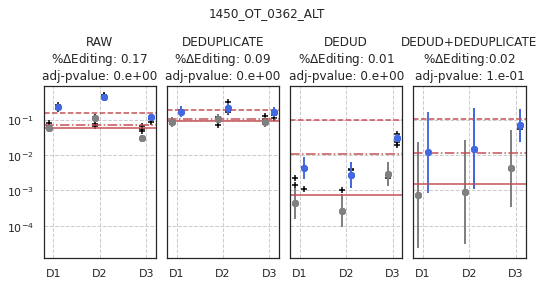

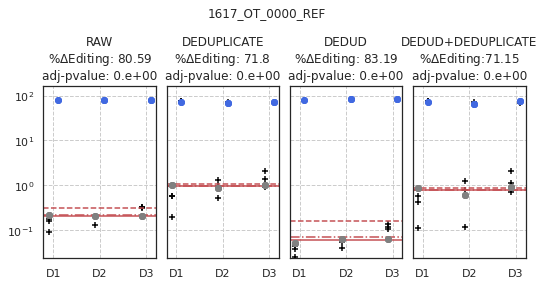

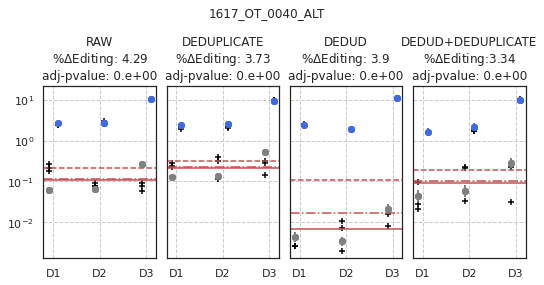

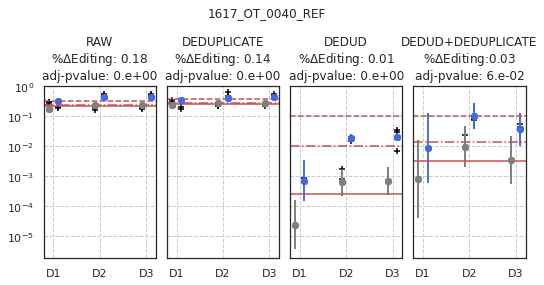

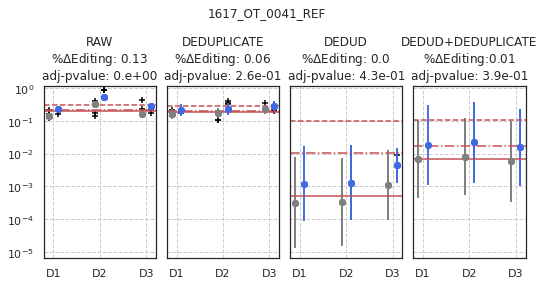

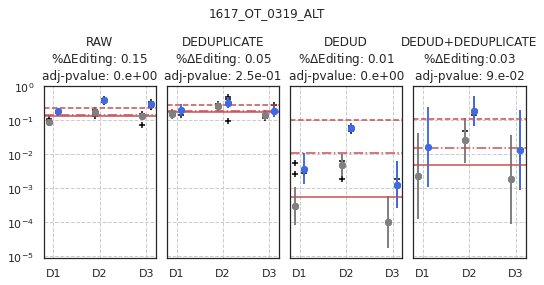

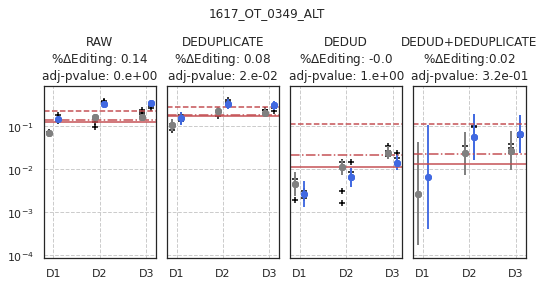

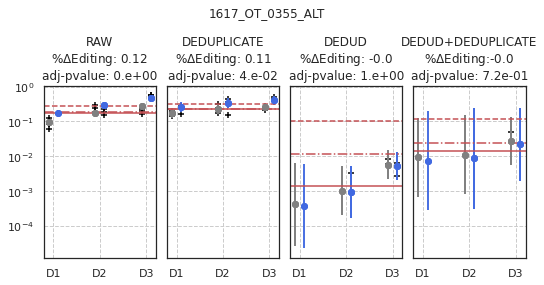

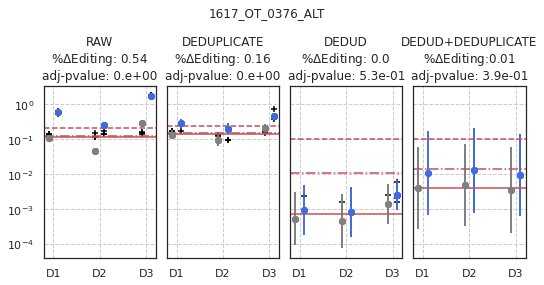

In [70]:
for ot in off_list:
    make_compare_scatter(ot, save_folder='./scatterplot_donor4S/')

# Check reads change due to different filtering strategies

In [303]:
heatmap_EST_noEP_list = []
heatmap_EST_HiFi_list = []
heatmap_SIG_HiFi_list = []
heatmap_CI_NoEP_list = []
heatmap_CI_HiFi_list = []
all_df_list = []
ds_size = ''
for n in ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS']:
    print(n)
    target_res_list = []
    for fn in glob.glob('././CRISPRessoBatch_alleles_umi/' + n + '/results/*'):
        if not fn.endswith('.png'):
            df = pd.read_csv(fn, sep='\t')
            df['Target'] = fn.split('/')[-1]
            target_res_list.append(df)
    danlio_res_df = pd.concat(target_res_list)
    danlio_res_df['conf.interval'] = danlio_res_df['conf.high'] - danlio_res_df['conf.low']
    danlio_res_df['name'] = danlio_res_df['Target'] + '-' + danlio_res_df['Donor'] + '-' + danlio_res_df['Treat']
    danlio_res_df['filtering_strategy'] = n
    all_df_list.append(danlio_res_df)
    noEP_res_df = danlio_res_df[danlio_res_df['Treat'] == 'NoEP']
    hifi_res_df = danlio_res_df[danlio_res_df['Treat'] == 'HiFi']
    noEP_res_dedup_df = noEP_res_df.drop_duplicates(subset='name')
    hifi_res_dedup_df = hifi_res_df.drop_duplicates(subset='name')
    
    heatmap_hifi_df = hifi_res_dedup_df.pivot("Target", "Donor", "predicted")
    hifi_res_dedup_df['Significant'] = (hifi_res_dedup_df['pvalueTreatPval'] < 0.05)&(hifi_res_dedup_df['pvalueTreatEst']>0)
    heatmap_hifi_sig_df = hifi_res_dedup_df.pivot("Target", "Donor", "Significant")
    heatmap_noEP_df = noEP_res_dedup_df.pivot("Target", "Donor", "predicted")
    for di in ['D3734', 'D3742', 'D3908']:
        heatmap_noEP_df = heatmap_noEP_df.rename(columns={di:di+'_'+n})
        heatmap_hifi_df = heatmap_hifi_df.rename(columns={di:di+'_'+n})
        heatmap_hifi_sig_df = heatmap_hifi_sig_df.rename(columns={di:di+'_'+n})
    heatmap_SIG_HiFi_list.append(heatmap_hifi_sig_df)
    heatmap_EST_HiFi_list.append(heatmap_hifi_df)
    heatmap_EST_noEP_list.append(heatmap_noEP_df)
    
    heatmap_hifi_df = hifi_res_dedup_df.pivot("Target", "Donor", "conf.interval")
    heatmap_noEP_df = noEP_res_dedup_df.pivot("Target", "Donor", "conf.interval")
    for di in ['D3734', 'D3742', 'D3908']:
        heatmap_noEP_df = heatmap_noEP_df.rename(columns={di:di+'_'+n})
        heatmap_hifi_df = heatmap_hifi_df.rename(columns={di:di+'_'+n})
    heatmap_CI_NoEP_list.append(heatmap_noEP_df)
    heatmap_CI_HiFi_list.append(heatmap_hifi_df)
    
all_df = pd.concat(all_df_list)
heatmap_EST_merged_noEP_df = pd.concat(heatmap_EST_noEP_list, axis=1)
heatmap_SIG_merged_HiFi_df = pd.concat(heatmap_SIG_HiFi_list, axis=1)
heatmap_EST_merged_HiFi_df = pd.concat(heatmap_EST_HiFi_list, axis=1)
heatmap_CI_merged_NoEP_df = pd.concat(heatmap_CI_NoEP_list, axis=1)
heatmap_CI_merged_HiFi_df = pd.concat(heatmap_CI_HiFi_list, axis=1)
# heatmap_EST_delta_df = heatmap_EST_merged_HiFi_df - heatmap_EST_merged_noEP_df
# heatmap_EST_merged_sig_df = heatmap_EST_delta_df> 0.1/100
all_df = pd.concat(all_df_list)

raw


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


raw_deduplicateS


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dedudStringentV3


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dedudStringentV3_deduplicateS


/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [304]:
all_df = all_df.reset_index()

In [305]:
for idx, row in all_df.iterrows():
    if row['Target'] == '1450_OT_0000_REF' or row['Target'] == '1617_OT_0000_REF':
        all_df.loc[idx, 'locus'] = 'On-target'
    else:
        all_df.loc[idx, 'locus'] = 'Off-target'

In [306]:
hifi_df = all_df[all_df['Treat'] == 'HiFi']
noEP_df = all_df[all_df['Treat'] == 'NoEP']

In [307]:
rc_df_list = []
for fs in ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS']:
    fs_df = hifi_df[hifi_df['filtering_strategy'] == fs]
    rc_df = fs_df.groupby('locus')[['cInd', 'cTot']].sum().reset_index()
    rc_df['cNoe'] = rc_df['cTot'] - rc_df['cInd']
    rc_df['filter'] = fs
    rc_df_list.append(rc_df)
hifi_rc_df = pd.concat(rc_df_list).reset_index()
hifi_rc_df['treat'] = 'HiFi'
rc_df_list = []
for fs in ['raw', 'raw_deduplicateS', 'dedudStringentV3', 'dedudStringentV3_deduplicateS']:
    fs_df = noEP_df[noEP_df['filtering_strategy'] == fs]
    rc_df = fs_df.groupby('locus')[['cInd', 'cTot']].sum().reset_index()
    rc_df['cNoe'] = rc_df['cTot'] - rc_df['cInd']
    rc_df['filter'] = fs
    rc_df_list.append(rc_df)
noEP_rc_df = pd.concat(rc_df_list).reset_index()
noEP_rc_df['treat'] = 'NoEP'

In [340]:
%matplotlib notebook

<IPython.core.display.Javascript object>


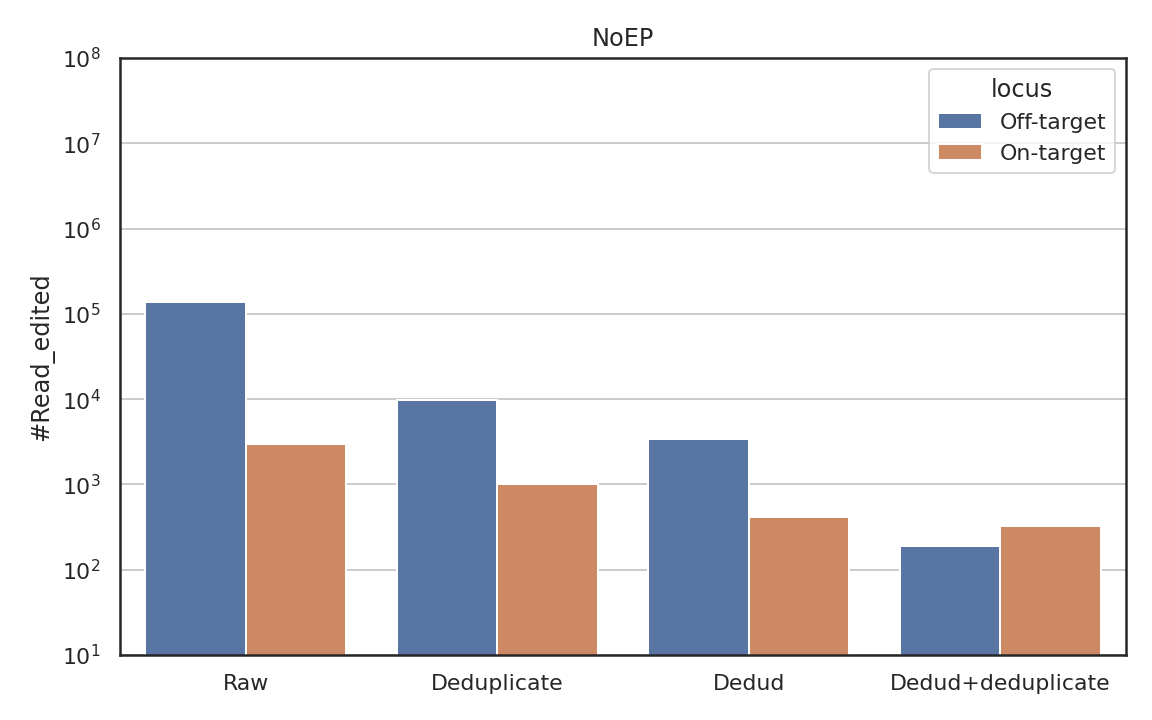

In [341]:
plt.figure(figsize=(8, 5))
sns.barplot(x='filter', y='value', hue='locus', data=noEP_rc_df.melt(id_vars=['filter', 'locus'], value_vars=['cInd']))
plt.ylabel('#Read_edited')
for i in ax.containers:
    ax.bar_label(i,fmt='%.2e')
plt.xlabel('')
plt.ylim(1e1, 1e8)
plt.title('NoEP')
plt.xticks(range(4), ['Raw', 'Deduplicate', 'Dedud', 'Dedud+deduplicate'])
plt.yscale('log')
plt.grid(axis='y')
plt.tight_layout()

<IPython.core.display.Javascript object>


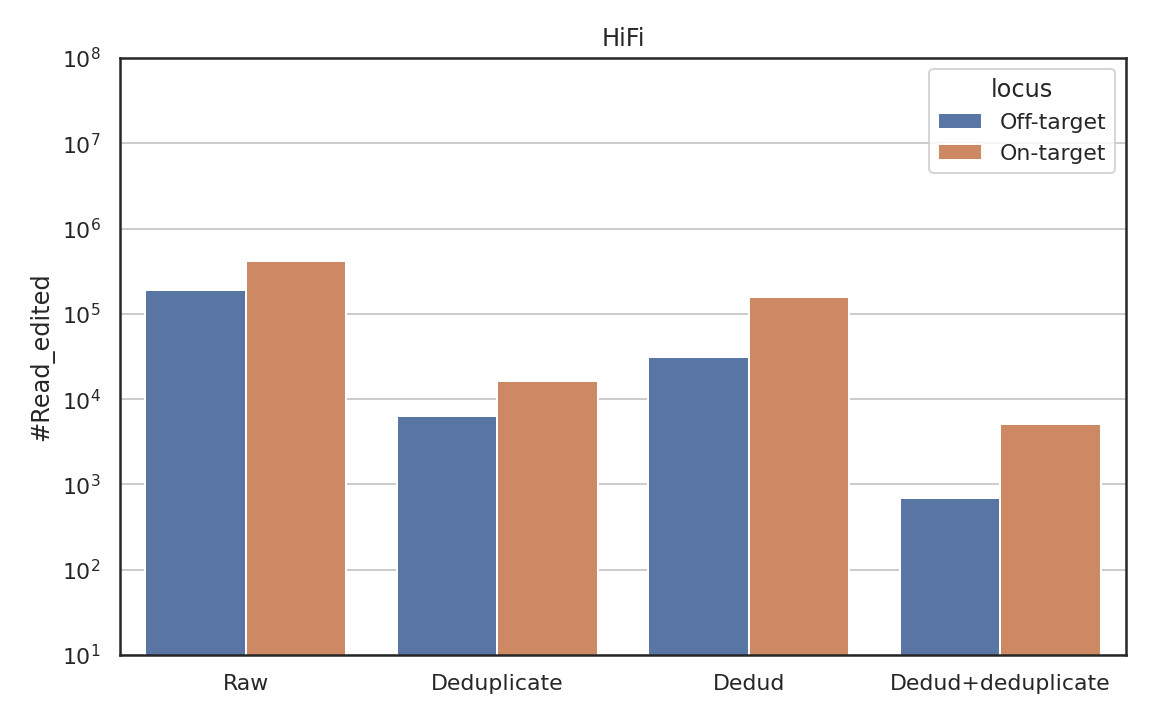

In [342]:
plt.figure(figsize=(8, 5))
sns.barplot(x='filter', y='value', hue='locus', data=hifi_rc_df.melt(id_vars=['filter', 'locus'], value_vars=['cInd']))
plt.ylabel('#Read_edited')
for i in ax.containers:
    ax.bar_label(i,fmt='%.2e')
plt.xlabel('')
plt.ylim(1e1, 1e8)
plt.title('HiFi')
plt.xticks(range(4), ['Raw', 'Deduplicate', 'Dedud', 'Dedud+deduplicate'])
plt.yscale('log')
plt.grid(axis='y')
plt.tight_layout()

<IPython.core.display.Javascript object>


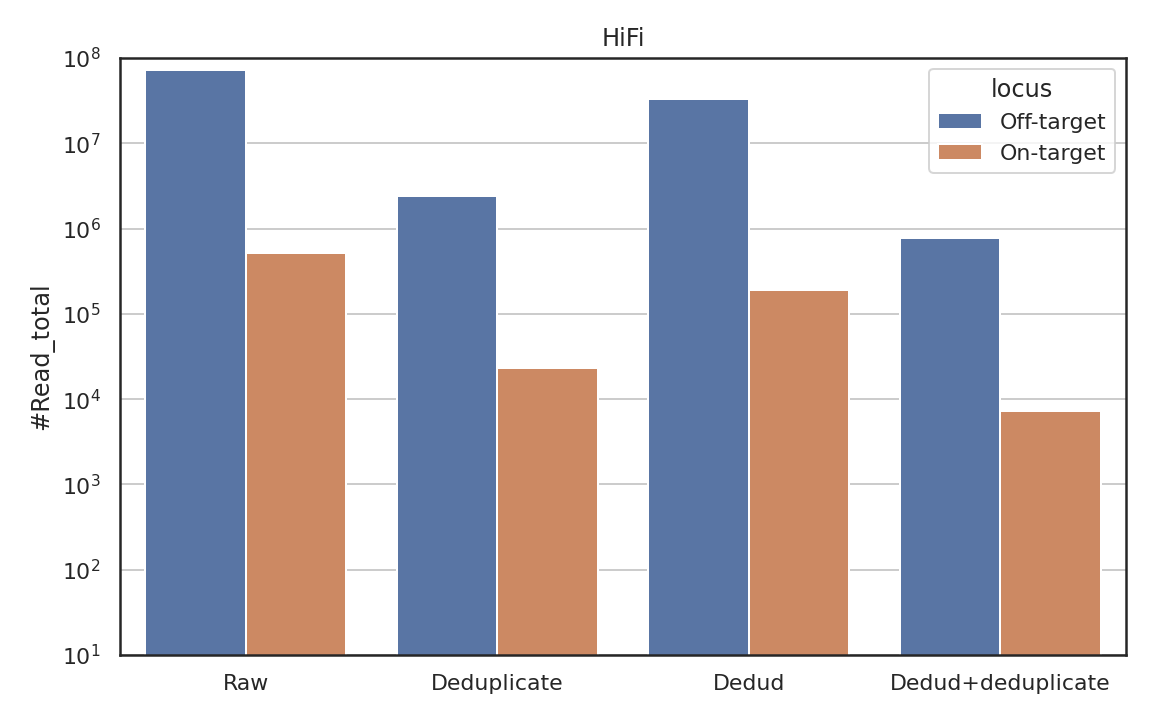

In [343]:
plt.figure(figsize=(8, 5))
sns.barplot(x='filter', y='value', hue='locus', data=hifi_rc_df.melt(id_vars=['filter', 'locus'], value_vars=['cTot']))
plt.ylabel('#Read_total')
for i in ax.containers:
    ax.bar_label(i,fmt='%.2e')
plt.xlabel('')
plt.ylim(1e1, 1e8)
plt.title('HiFi')
plt.xticks(range(4), ['Raw', 'Deduplicate', 'Dedud', 'Dedud+deduplicate'])
plt.yscale('log')
plt.grid(axis='y')
plt.tight_layout()

<IPython.core.display.Javascript object>


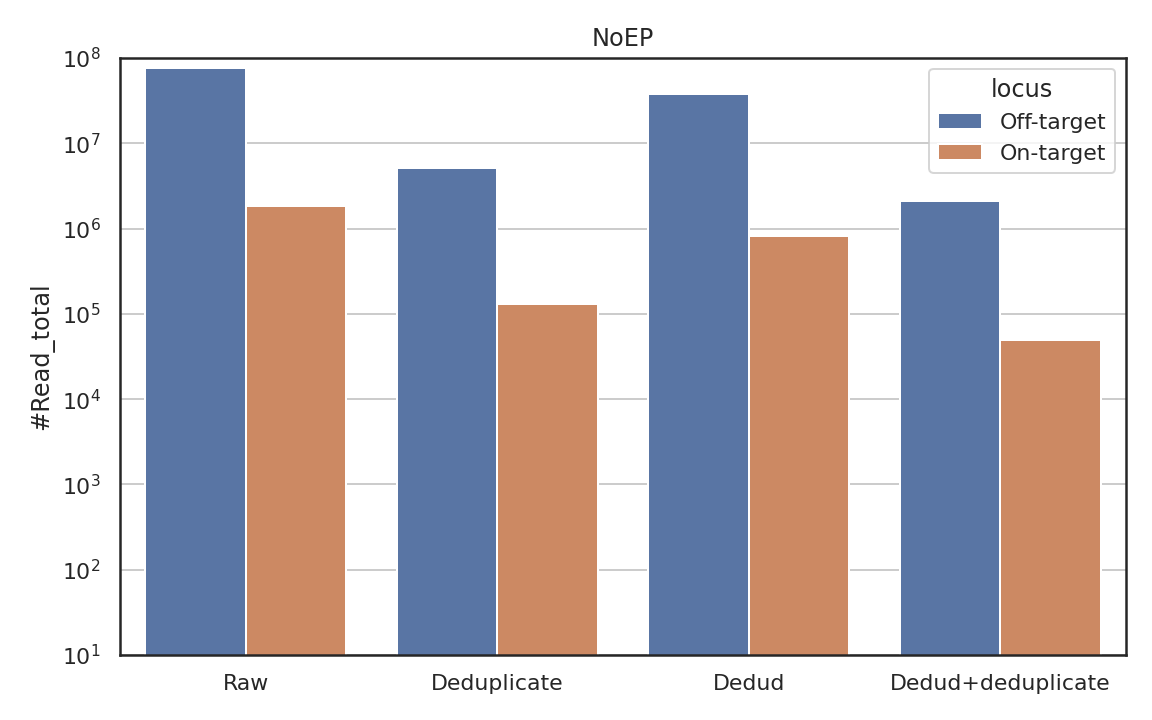

In [344]:
plt.figure(figsize=(8, 5))
sns.barplot(x='filter', y='value', hue='locus', data=noEP_rc_df.melt(id_vars=['filter', 'locus'], value_vars=['cTot']))
plt.ylabel('#Read_total')
for i in ax.containers:
    ax.bar_label(i,fmt='%.2e')
plt.xlabel('')
plt.ylim(1e1, 1e8)
plt.title('NoEP')
plt.xticks(range(4), ['Raw', 'Deduplicate', 'Dedud', 'Dedud+deduplicate'])
plt.yscale('log')
plt.grid(axis='y')
plt.tight_layout()

In [249]:
noEP_rc_df.melt(id_vars=['filter', 'isOnTarget'], value_vars=['cInd', 'cNoe']).reset_index(

,index,filter,isOnTarget,variable,value
0,0,raw,False,cInd,136791
1,1,raw,True,cInd,2968
2,2,raw_deduplicateS,False,cInd,9858
3,3,raw_deduplicateS,True,cInd,1014
4,4,dedudStringentV3,False,cInd,3401
5,5,dedudStringentV3,True,cInd,417
6,6,dedudStringentV3_deduplicateS,False,cInd,191
7,7,dedudStringentV3_deduplicateS,True,cInd,323
8,8,raw,False,cNoe,76875714
9,9,raw,True,cNoe,1817216


In [235]:
%matplotlib inline

In [223]:
ax = maxi_reads.drop(columns=['umi']).set_index('Maxi_id').plot(kind='bar', stacked=True, figsize=(6, 6))
plt.xticks(rotation=0)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2e')
plt.xlabel('')
plt.ylabel('#Reads')
plt.tight_layout()

,index,isOnTarget,cInd,cTot,cNoe,filter
0,0,False,324790,148671532,148346742,raw
1,1,True,417037,2339063,1922026,raw
2,0,False,16245,7496895,7480650,raw_deduplicateS
3,1,True,17552,153263,135711,raw_deduplicateS
4,0,False,34450,71128752,71094302,dedudStringentV3
5,1,True,160007,1002496,842489,dedudStringentV3
6,0,False,887,2870842,2869955,dedudStringentV3_deduplicateS
7,1,True,5481,56904,51423,dedudStringentV3_deduplicateS


In [918]:
readChange_df['cTot%'] = readChange_df['cTot']/151010595
readChange_df['cInd%'] = readChange_df['cInd']/741827

In [910]:
readChange_df

,filtering_strategy,cInd,cTot,cTot%,cInd%
0,dedudStringentV3,194457,72131248,0.477657,0.262133
1,dedudStringentV3_deduplicateS,6368,2927746,0.019388,0.008584
2,raw,741827,151010595,1.000000,1.000000
3,raw_deduplicateS,33797,7650158,0.050660,0.045559


In [911]:
df1 = readChange_df[['filtering_strategy', 'cInd']]
df1.columns = ['filtering strategy', 'reads']
df1['type'] = 'edited'
df2 = readChange_df[['filtering_strategy', 'cTot']]
df2.columns = ['filtering strategy', 'reads']
df2['type'] = 'total'
readChange_df = pd.concat([df1, df2]).reset_index()

/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [912]:
readChange_df0

,index,filtering strategy,reads,type
0,0,dedudStringentV3,194457,edited
1,1,dedudStringentV3_deduplicateS,6368,edited
2,2,raw,741827,edited
3,3,raw_deduplicateS,33797,edited
4,0,dedudStringentV3,72131248,total
5,1,dedudStringentV3_deduplicateS,2927746,total
6,2,raw,151010595,total
7,3,raw_deduplicateS,7650158,total


In [863]:
%matplotlib notebook

<IPython.core.display.Javascript object>


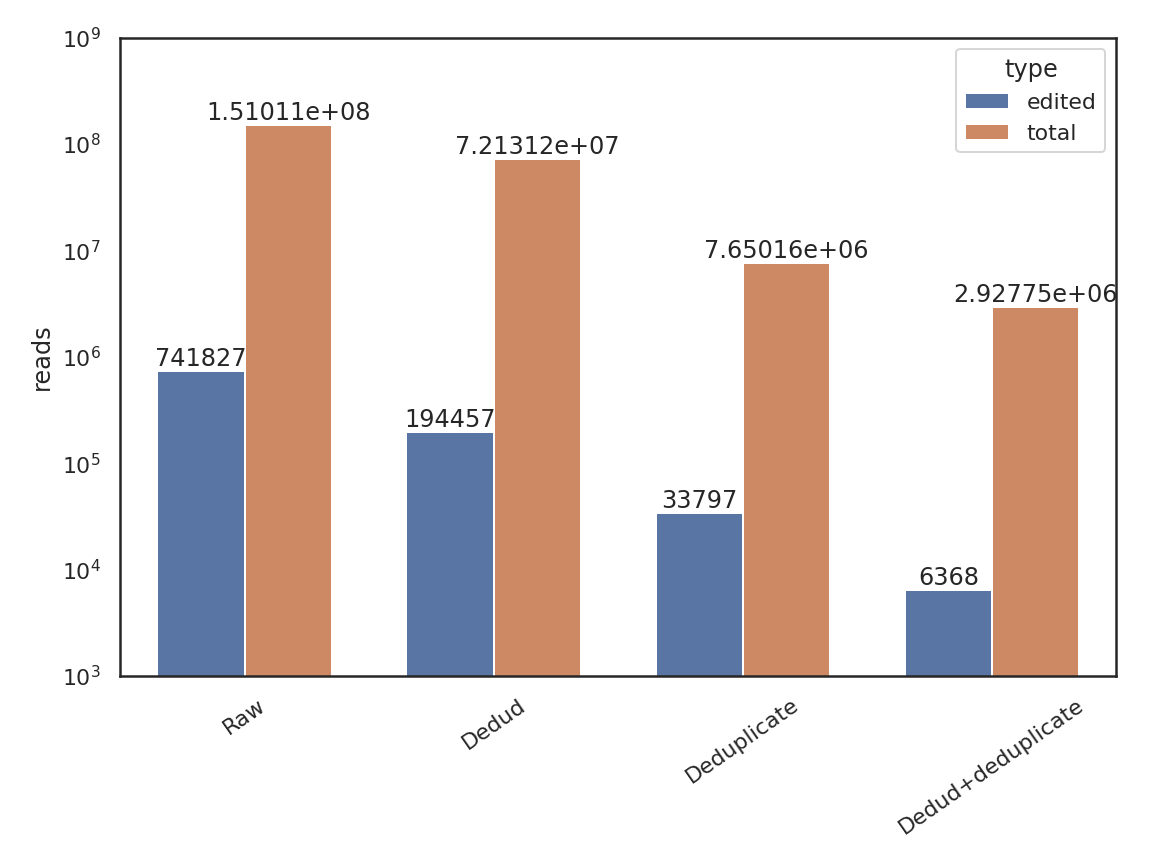

In [913]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(y='reads', x='filtering strategy', hue='type', order=['raw', 'dedudStringentV3', 'raw_deduplicateS', 'dedudStringentV3_deduplicateS'], data=readChange_df, width=0.7)
plt.yscale('log')
for i in ax.containers:
    ax.bar_label(i,)
plt.xticks([0, 1, 2, 3],['Raw', 'Dedud', 'Deduplicate', 'Dedud+deduplicate'], rotation='35')
plt.xlabel('')
plt.ylim(1e3, 1e9)
plt.tight_layout()

<IPython.core.display.Javascript object>


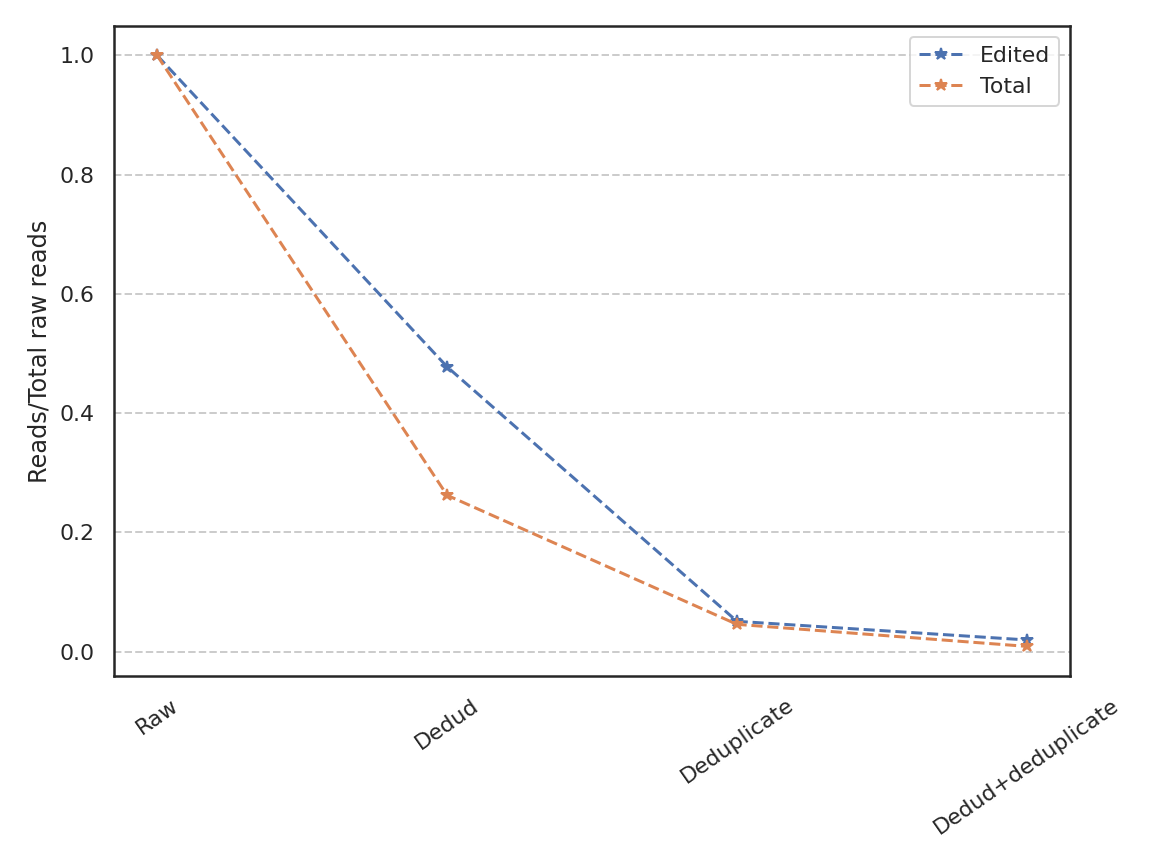

In [922]:
plt.figure(figsize=(8, 6))
cTot_df = readChange_df.sort_values(by='cTot%', ascending=False)
cInd_df = readChange_df.sort_values(by='cInd%', ascending=False)
plt.plot(tot_df['filtering_strategy'], tot_df['cTot%'], '*--', label='Edited')
plt.plot(cInd_df['filtering_strategy'], cInd_df['cInd%'], '*--', label='Total')
plt.xticks([0, 1, 2, 3],['Raw', 'Dedud', 'Deduplicate', 'Dedud+deduplicate'], rotation='35')
plt.legend()
plt.ylabel('Reads/Total raw reads')
plt.grid(linestyle = '--', axis='y')
plt.tight_layout()

In [884]:
readChange_df

,filtering_strategy,cInd,cTot,cTot%,cInd%
0,dedudStringentV3,194457,72131248,1.000000,0.262133
1,dedudStringentV3_deduplicateS,6368,2927746,0.040589,0.008584
2,raw,741827,151010595,2.093553,1.000000
3,raw_deduplicateS,33797,7650158,0.106059,0.045559
